<center><img src="https://ucare.timepad.ru/0c6f838c-2f68-4712-bdbe-a9aefde7c2d5/-/preview/1248x1248/-/format/jpeg/poster_event_2317816.jpg" ></center>

<center><h1 style="text-align: center;"><b>TGT Digital Challenge</b></h1><center>

<h2 style="text-align: center;"><b>Разработка автоматического распознавателя удара песчинок на аудиоданных</b></h2>

---

# 1. Библиотеки и данные

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

import librosa

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from catboost import Pool, cv, CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub_sample = pd.read_csv('submission_sample.csv')

In [3]:
train.shape, test.shape, sub_sample.shape

((3792, 301), (450, 300), (450, 1))

In [4]:
train.head(10)

data_1    data_2    data_3    data_4    data_5    data_6    data_7  \
0 -0.266033 -0.496437 -0.572447 -0.220903  0.266033  0.643705  0.365796   
1  0.125475 -0.007605 -0.030418  0.285171  0.574144  0.418251  0.304183   
2  0.130435  0.445652  0.358696  0.086957 -0.076087  0.173913  0.173913   
3  0.032628 -0.019400  0.033510 -0.009700  0.037919 -0.014109  0.008818   
4  0.006105  0.005723  0.004197 -0.001145 -0.009538 -0.009538 -0.000382   
5  0.001224  0.000908  0.000553  0.000750  0.000237  0.000395 -0.000434   
6  0.028025 -0.127389 -0.210191 -0.438217 -0.457325 -0.226752  0.096815   
7 -0.724638 -0.311594  0.050725  0.586957  0.557971  0.804348  0.217391   
8  0.694309  0.643902  0.878049  0.442276  0.279675  0.058537 -0.216260   
9 -0.325123 -0.157635  0.231527  0.044335  0.352217 -0.211823  0.399015   

     data_8    data_9   data_10  ...  data_292  data_293  data_294  data_295  \
0  0.375297  0.014252 -0.527316  ...       NaN       NaN       NaN       NaN   
1  0.277567  0.433460  0.231939  ...       NaN       NaN       NaN       NaN   
2  0.304348  0.141304  0.304348  ...       NaN       NaN       NaN       NaN   
3 -0.005291  0.027337 -0.037919  ...       NaN       NaN       NaN       NaN   
4 -0.006868 -0.006105 -0.012591  ...       NaN       NaN       NaN       NaN   
5  0.000513  0.000158  0.000474  ...  0.011407 -0.008604  0.003197 -0.015077   
6  0.375796  0.551592  0.615287  ...       NaN       NaN       NaN       NaN   
7  0.144928 -0.014493 -0.369565  ...       NaN       NaN       NaN       NaN   
8  0.411382  0.621138  0.068293  ...       NaN       NaN       NaN       NaN   
9 -0.280788 -0.881773 -0.440887  ...       NaN       NaN       NaN       NaN   

   data_296  data_297  data_298  data_299  data_300  label  
0       NaN       NaN       NaN       NaN       NaN      0  
1       NaN       NaN       NaN       NaN       NaN      0  
2       NaN       NaN       NaN       NaN       NaN      0  
3       NaN       NaN       NaN       NaN       NaN      1  
4       NaN       NaN       NaN       NaN       NaN      0  
5 -0.003789 -0.002092 -0.001579 -0.008249 -0.001579      1  
6       NaN       NaN       NaN       NaN       NaN      0  
7       NaN       NaN       NaN       NaN       NaN      0  
8       NaN       NaN       NaN       NaN       NaN      0  
9       NaN       NaN       NaN       NaN       NaN      0  

[10 rows x 301 columns]

Распределение таргета

In [5]:
targets = train['label']
targets.value_counts()

0    3130
1     662
Name: label, dtype: int64

# 2. EDA (Разведочный анализ) и Предобработка данных

In [6]:
sns.set(rc={'figure.figsize':(22, 10)})
sns.set_style('whitegrid')

def draw_data(data, c_plots=10):
    
    label_0 = list(train[train['label']==0]['label'].head(c_plots).index)
    label_1 = list(train[train['label']==1]['label'].head(c_plots).index)

    for i in range(c_plots):
        fig, ax = plt.subplots(1,2)
        sns.set_context("notebook", 
                        font_scale=1, 
                        rc={"lines.linewidth": 2})

        non_missing_values_0 = data[label_0[i]][~np.isnan(data[label_0[i]])]
        non_missing_values_1 = data[label_1[i]][~np.isnan(data[label_1[i]])]

        plot = sns.lineplot(x=list(range(len(non_missing_values_0))), 
                     y=non_missing_values_0, ax=ax[0]);
        sns.scatterplot(x=list(range(len(non_missing_values_0))), 
                        y=non_missing_values_0, ax=ax[0]);
        plot.set_xlabel("Signal number", fontsize=13)
        plot.set_ylabel("Amplitude", fontsize=13)
        plot.set_title("Label: 0, Index: " + str(label_0[i]), fontsize=15);

        plot = sns.lineplot(x=list(range(len(non_missing_values_1))), 
                     y=non_missing_values_1, ax=ax[1]);
        sns.scatterplot(x=list(range(len(non_missing_values_1))), 
                        y=non_missing_values_1, ax=ax[1]);
        plot.set_xlabel("Signal number", fontsize=13)
        plot.set_ylabel("Amplitude", fontsize=13)
        plot.set_title("Label: 1, Index: " + str(label_1[i]), fontsize=15);


### Исходные данные

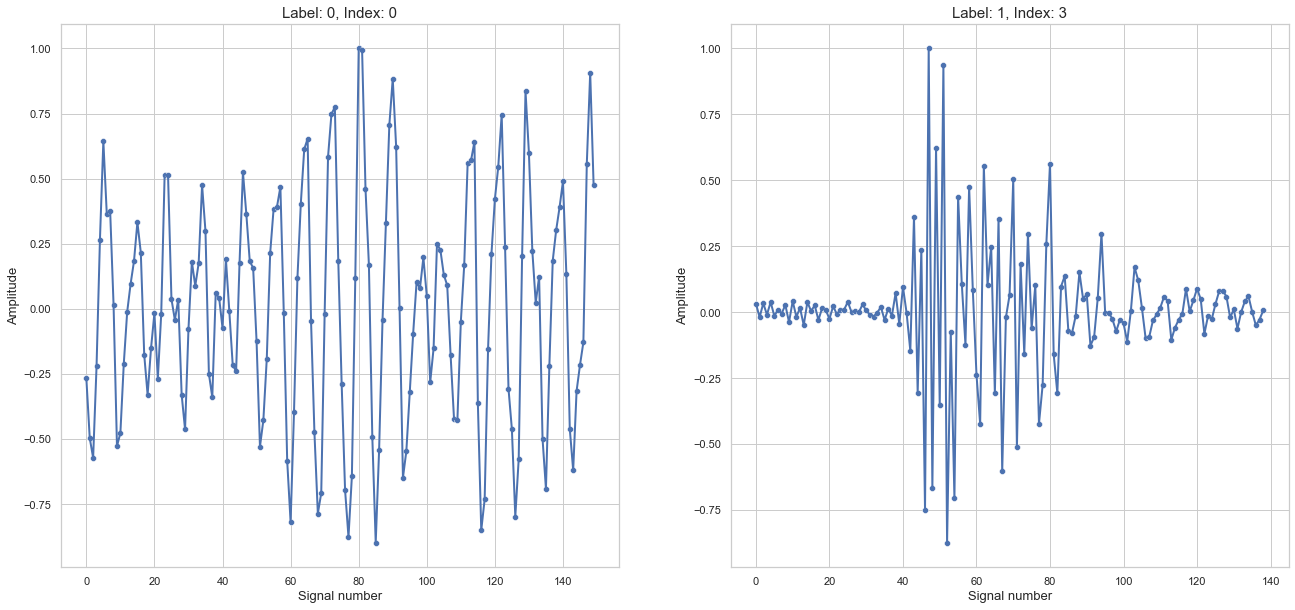

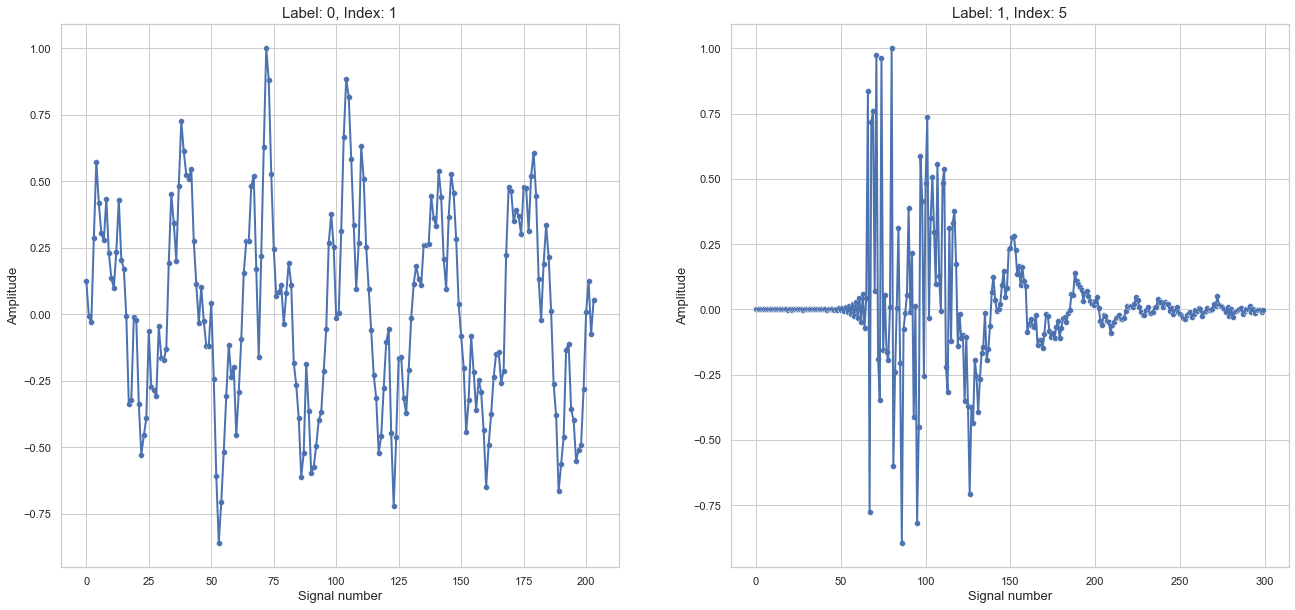

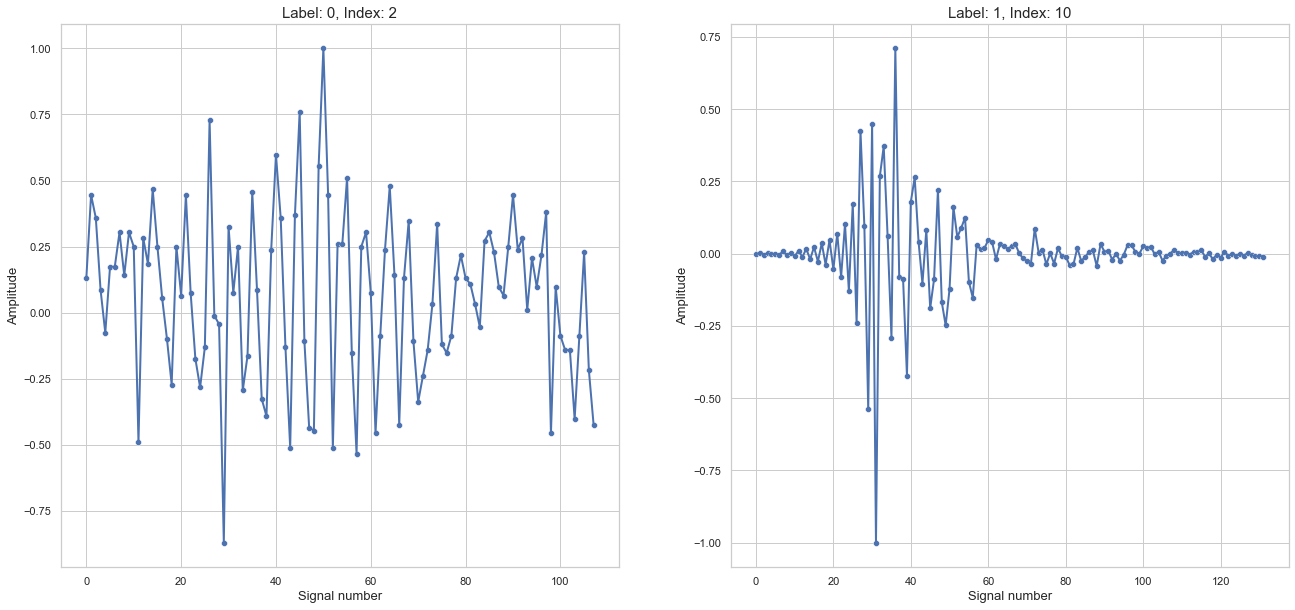

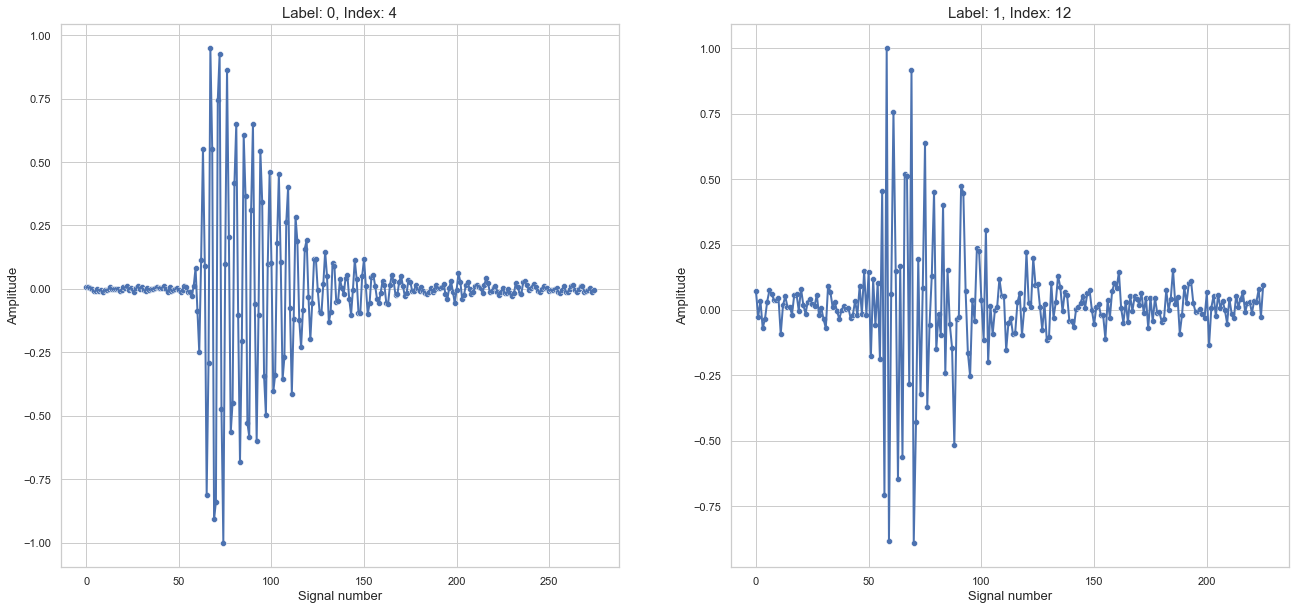

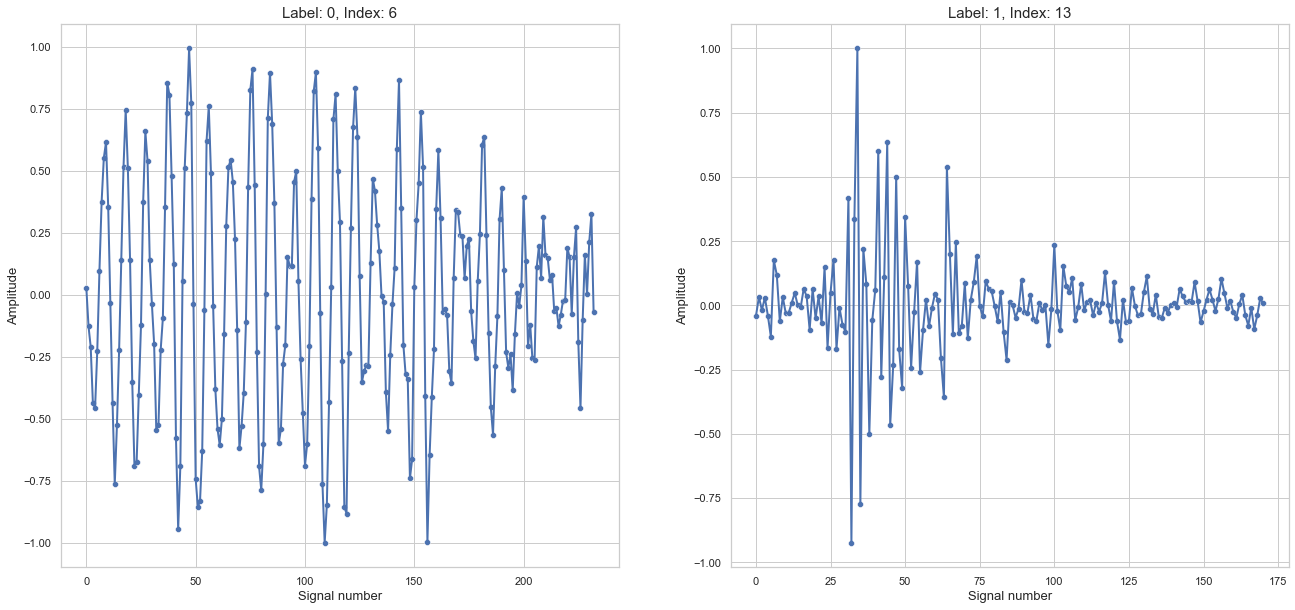

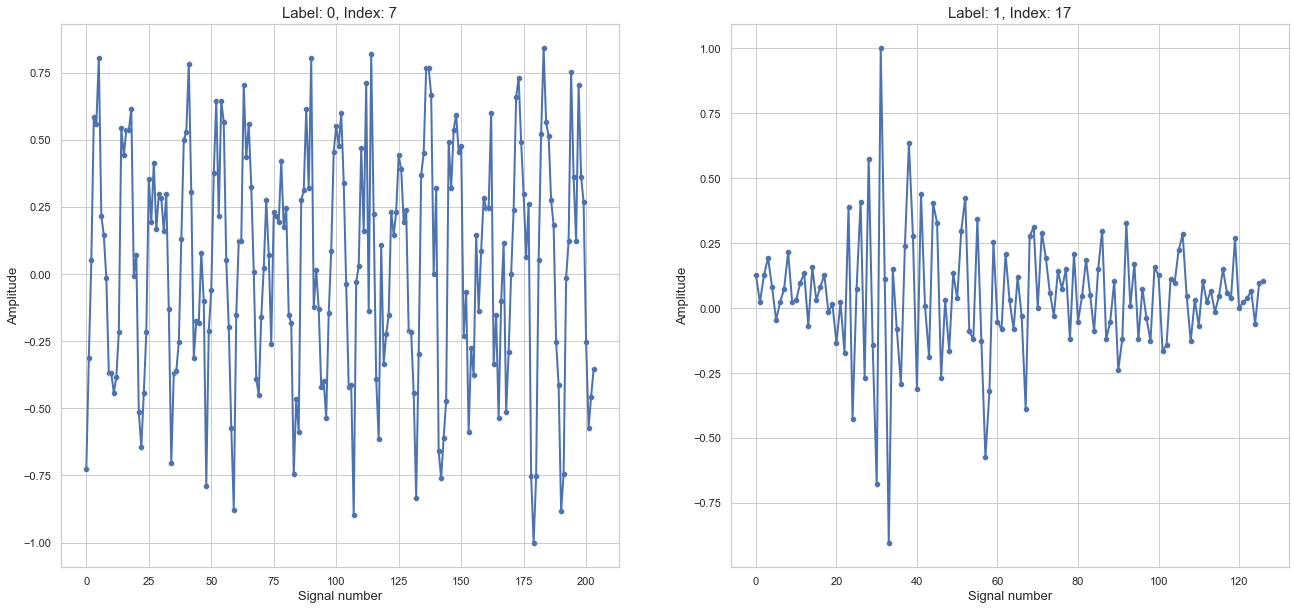

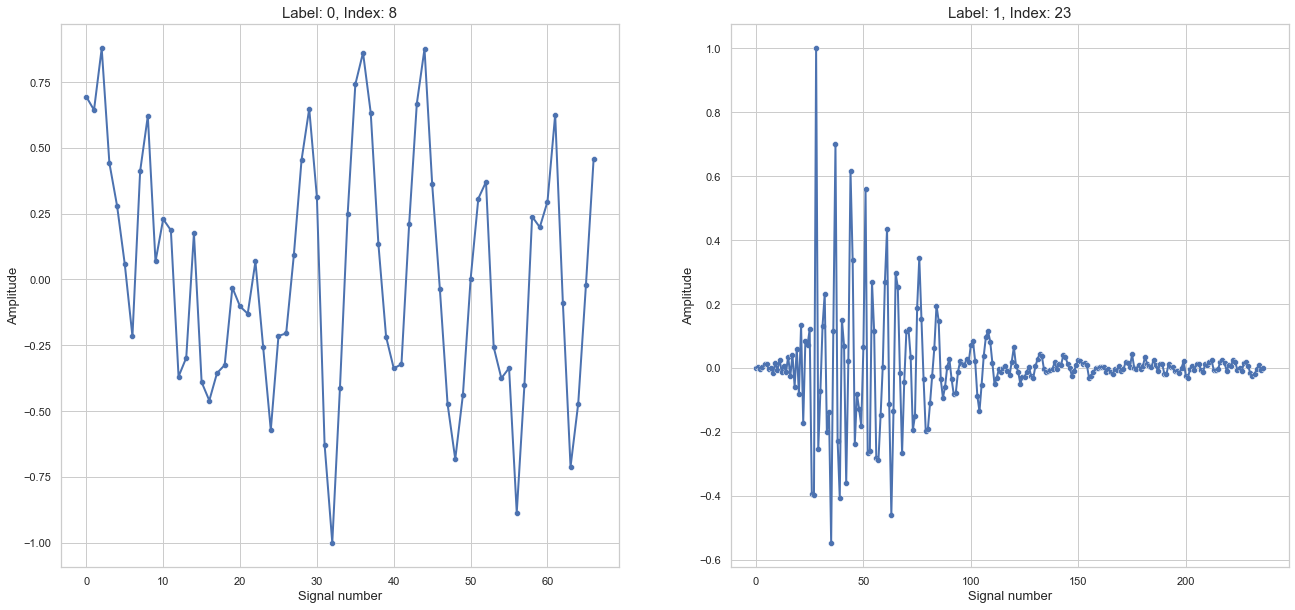

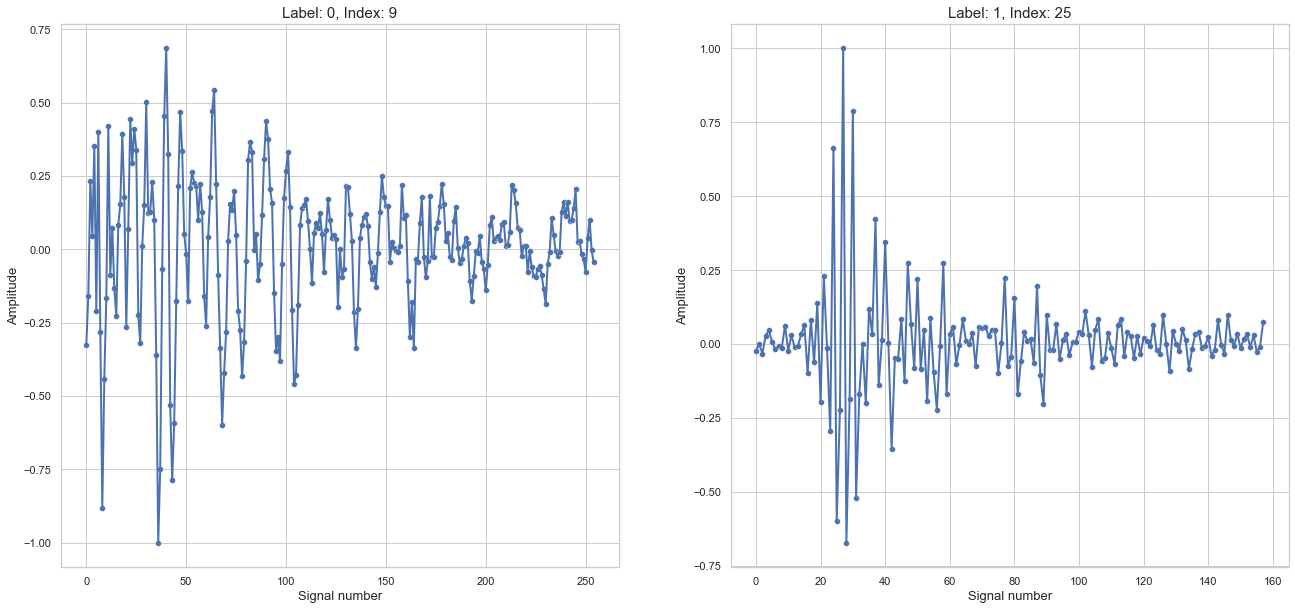

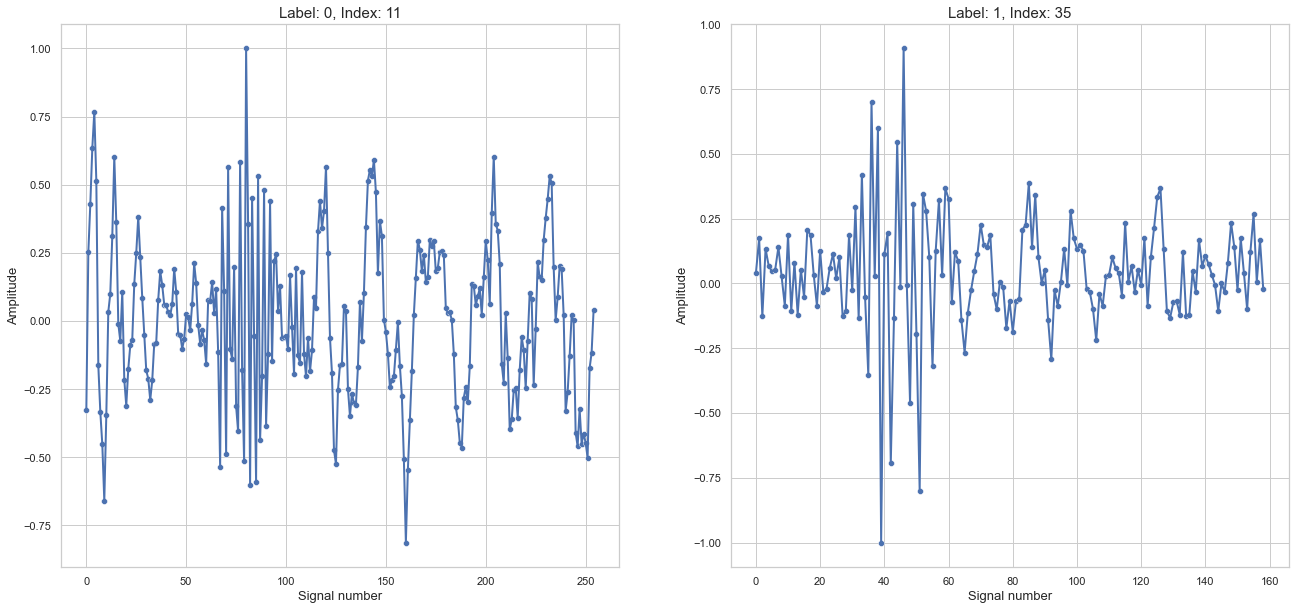

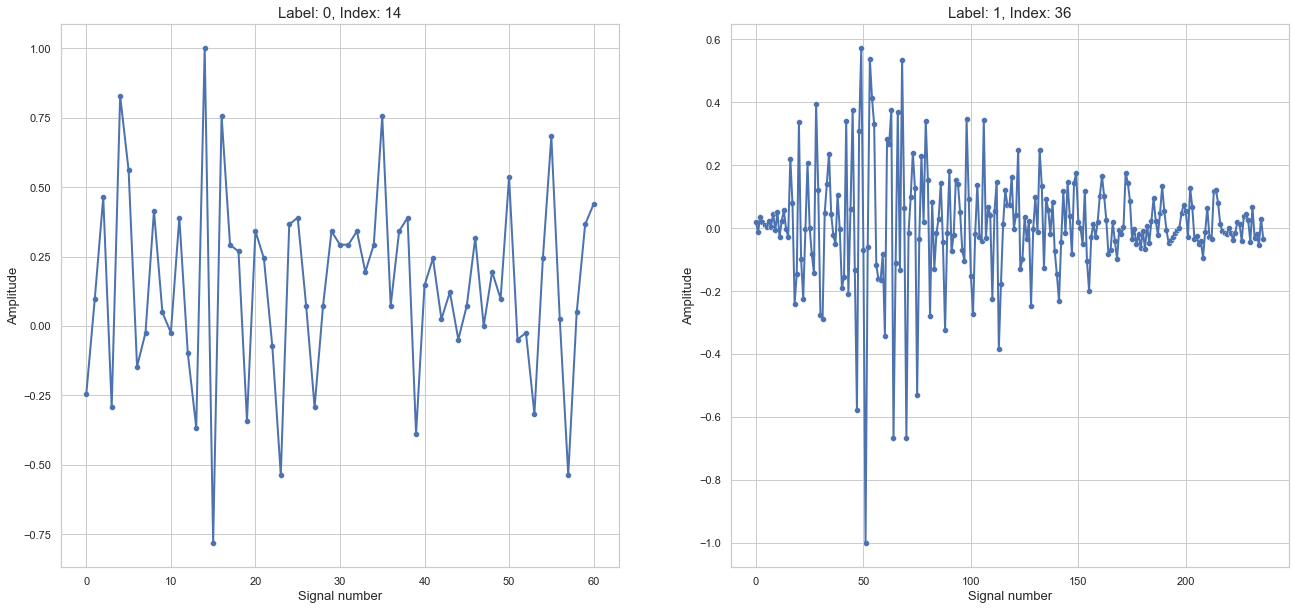

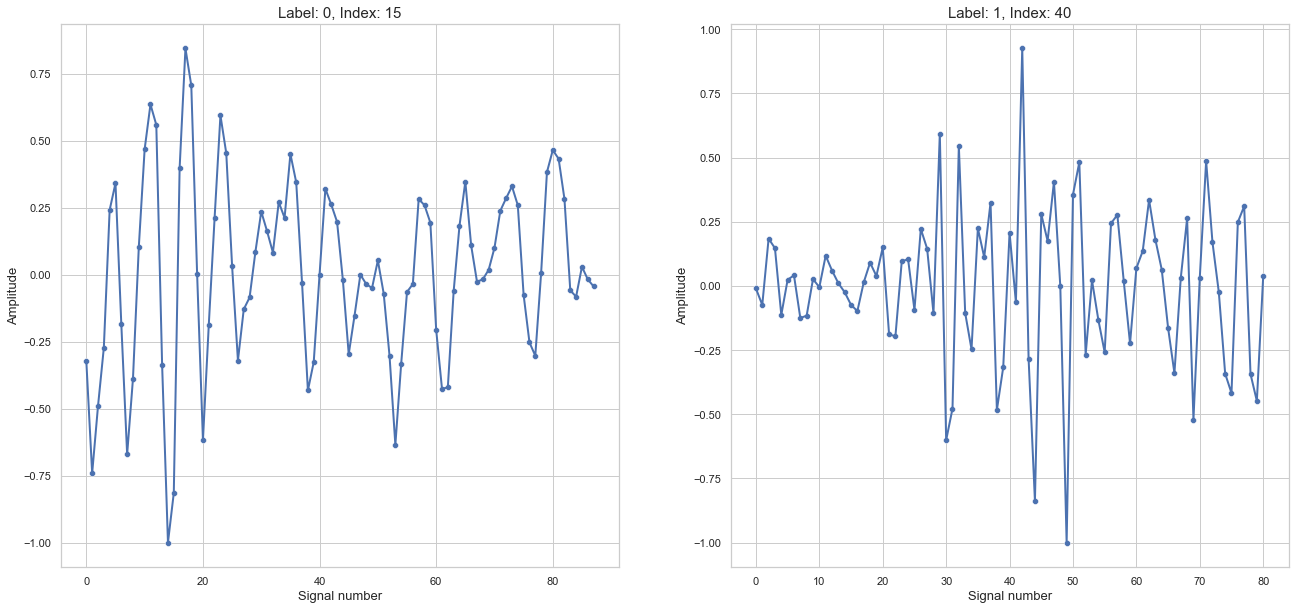

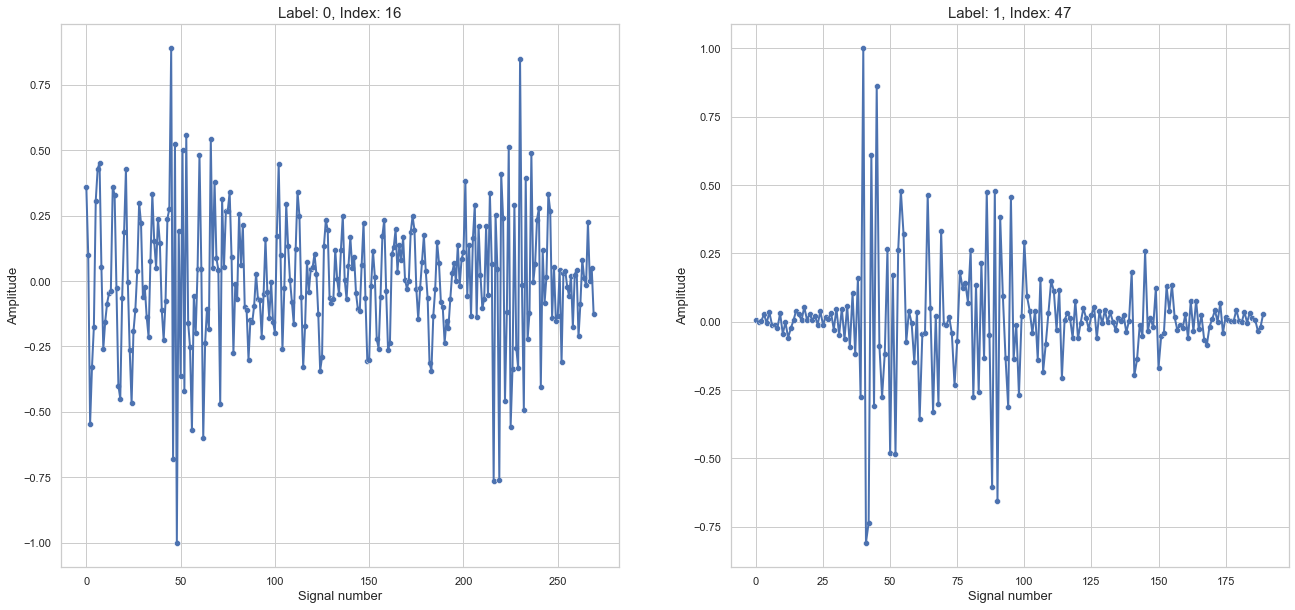

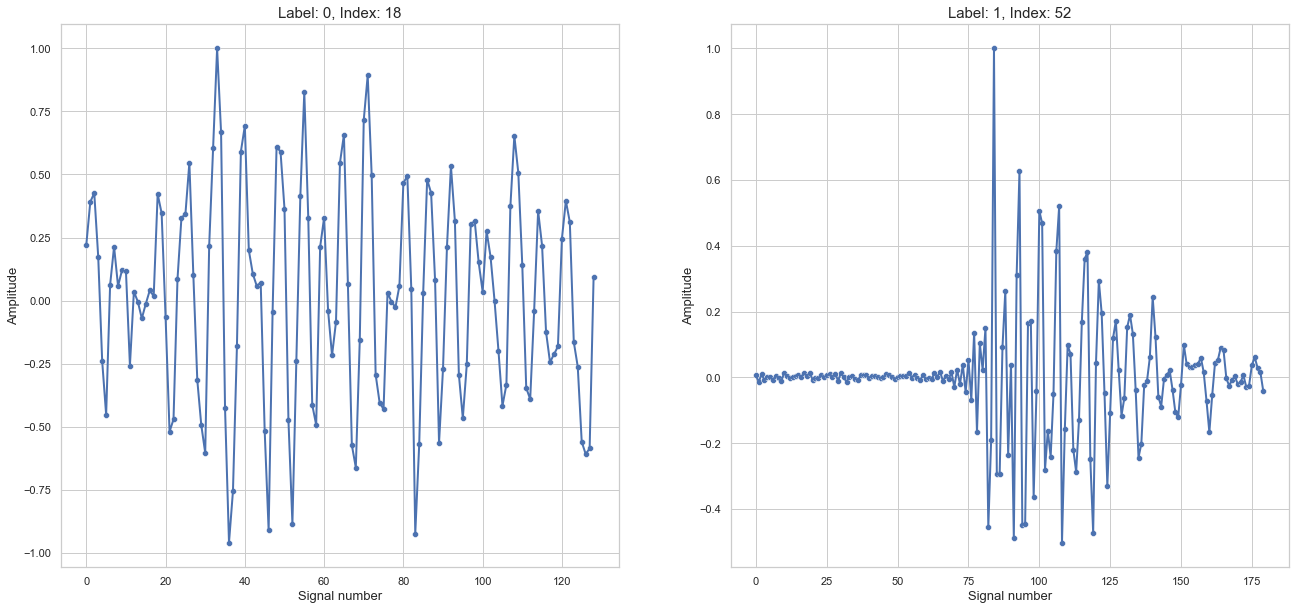

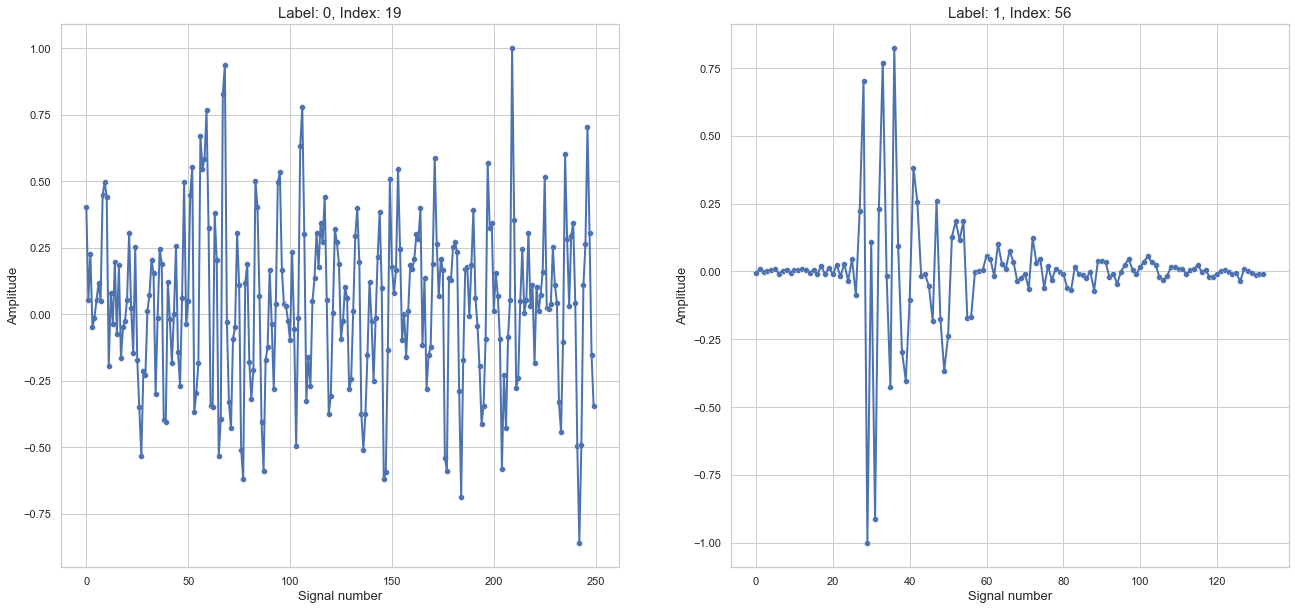

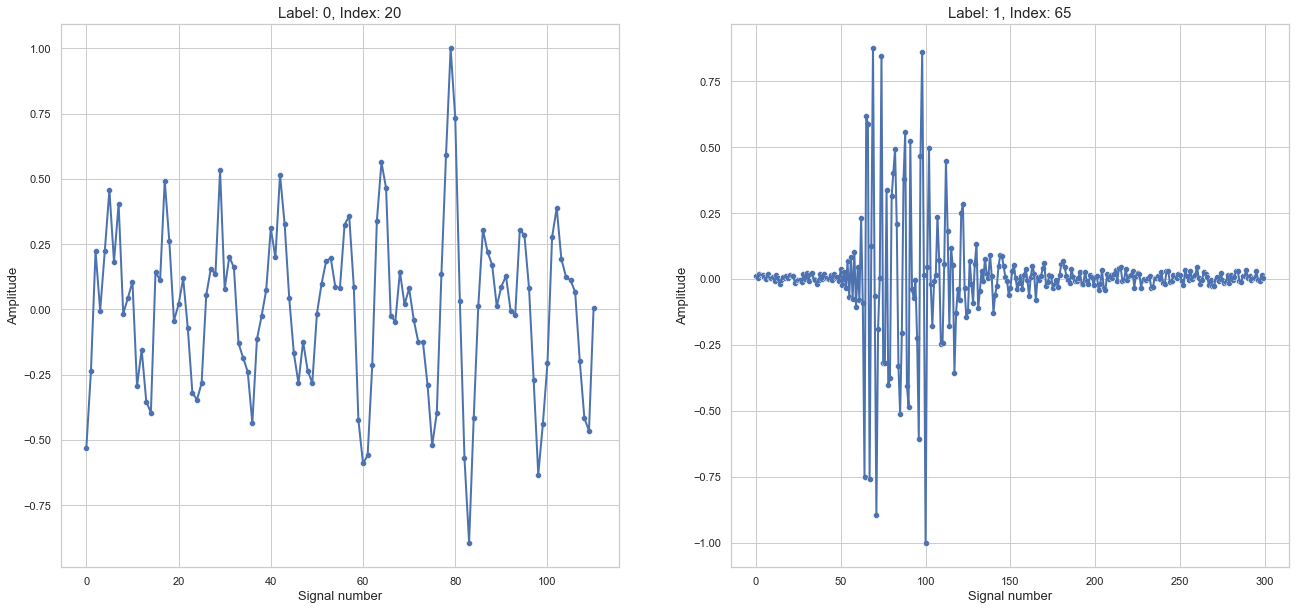

In [7]:
raw_data_train = train.drop('label', axis=1).values
raw_data_test = test.values

draw_data(raw_data_train, 15)

### Функции для обработки данных и извлечения признаков

In [8]:
def generate_features_from_ts(data):
    """
    Функция для извлечения признаков из временного ряда.

    Аргументы:
    data -- pandas dataframe с временным рядом

    Возвращает:
    признаки в виде массива numpy
    """
    # преобразуем датафрейм в массив numpy
    data = data.values
    
    # выделяем значения, которые не являются пропущенными
    non_miss_values = data[~np.isnan(data)]

    # создаем датафрейм из непропущенных значений
    df = pd.DataFrame({'ts': non_miss_values})

    # извлекаем признаки из датафрейма
    features = df.describe().T.drop(['count'], axis=1).values
    
    # возвращаем признаки в виде массива numpy
    return features


def squared_std_sums(data):
    """
    Функция для вычисления суммы квадратов стандартных отклонений временного ряда.

    Аргументы:
    data -- pandas dataframe с временным рядом

    Возвращает:
    кортеж из двух значений:
    - сумма квадратов стандартных отклонений
    - сумма квадратов стандартных отклонений, поделенная на длину временного ряда
    """
    # преобразуем датафрейм в массив numpy
    data = data.values
    
    # выделяем значения, которые не являются пропущенными
    non_miss_values = data[~np.isnan(data)]
    
    # выделяем значения, которые являются пропущенными
    miss_values = data[np.isnan(data)]

    # создаем серию из нулей с длиной, равной количеству непропущенных значений
    null_values = pd.Series([0 for i in range(len(non_miss_values))])
    
    # вычисляем сумму квадратов стандартных отклонений
    squared_std = np.sum(np.square(non_miss_values - null_values))
    
    # вычисляем сумму квадратов стандартных отклонений, поделенную на длину временного ряда
    squared_std_per_len = np.sum(np.square(non_miss_values - null_values)) / len(non_miss_values)
    
    # возвращаем кортеж из двух значений
    return squared_std, squared_std_per_len


def count_sign_reversals(data):
    """
    Функция для подсчета количества переключений знака во временном ряде.

    Аргументы:
    data -- pandas dataframe с временным рядом

    Возвращает:
    количество переключений знака во временном ряде
    """
    # преобразуем датафрейм в массив numpy
    data = data.values
    
    # выделяем значения, которые не являются пропущенными
    non_miss_values = data[~np.isnan(data)]

    # создаем итератор из списка значений, которые не являются пропущенными
    it = iter(non_miss_values.tolist())
    
    # определяем знак первого значения
    sign = next(it, 0) < 0
    
    # счетчик количества переключений знака
    count = 0
    
    # проходим по оставшимся значениям и считаем количество переключений знака
    for n in it:
        if sign is not (n < 0):
            count += 1
            sign = not sign
    
    # возвращаем количество переключений знака во временном ряде
    return count


def extract_audio_features(data):
    """
    Функция для подготовки данных перед извлечением признаков из звукового файла.
    Эта функция вычисляет спектральную плотность мощности звукового файла и извлекает несколько признаков из этой плотности: 
    спектральный центроид, ширину полосы пропускания, плоскость спектра, спектральную огибающую и количество пересечений нуля.
    
    Аргументы:
    data -- pandas dataframe с звуковым файлом

    Возвращает:
    pandas dataframe с извлеченными признаками
    """
    # параметры анализа звукового файла
    frame_size = 2048
    hop_length = 512
    sr = 117.2
    
    # преобразуем датафрейм в массив numpy и удаляем пропущенные значения
    data = data.values
    data = data[~np.isnan(data)]
    
    # вычисляем спектральную плотность мощности
    power_spec = np.abs(librosa.stft(data))**2
    spectral_power_density = librosa.power_to_db(power_spec, ref=np.max)

    # вычисляем частоты
    freqs = librosa.fft_frequencies(sr=sr, n_fft=frame_size)

    # извлекаем признаки
    features = pd.DataFrame()
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=data, sr=sr)[0]
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=data, sr=sr)[0]
    features['spectral_flatness'] = librosa.feature.spectral_flatness(y=data)[0]
    features['spectral_rolloff'] = librosa.feature.spectral_rolloff(y=data, sr=sr)[0]
    features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(data)[0]
    
    # возвращаем numpy-array с извлеченными признаками
    return features.values


In [9]:
def preprocessing_data(data):
    # определяем имена столбцов для исходных данных и спектральных данных
    data_cols = ["data_" + str(i + 1) for i in range(300)]
    spec_data_cols = ["s_" + data_cols[i] for i in range(150)]

    # вычисляем статистические характеристики исходных данных
    statistical_signs = ["mean", "std", "min", "feature_25%", "feature_50%", "feature_75%", "max"]
    data[statistical_signs] = pd.DataFrame(data[data_cols].apply(lambda row: generate_features_from_ts(row)[0], axis=1).to_list(),
                                           columns=statistical_signs)

    # вычисляем сумму квадратов отклонений от оси x
    data[['squared_std_sum', 'squared_std_sum_per_len']] = pd.DataFrame(data[data_cols]\
                                                                        .apply(lambda row: squared_std_sums(row), axis=1).to_list(),
                                                                        columns=['squared_std_sum', 'squared_std_sum_per_len'])
    data['sq_squared_std_sum'] = data['squared_std_sum'] ** 2

    # производим паддинг пропущенных значений
    linear_extrapolation = data[data_cols].interpolate(method='linear', limit_area='outside', axis=1)

    # используем быстрое преобразование Фурье для обработки исходных данных
    data[spec_data_cols] = pd.DataFrame(np.abs(np.fft.fft(linear_extrapolation, axis=1))).iloc[:, 0:150]

    # вычисляем статистические характеристики спектральных данных
    spec_statistical_signs = ["s_" + statistical_signs[i] for i in range(len(statistical_signs))]
    data[spec_statistical_signs] = pd.DataFrame(data[spec_data_cols].apply(lambda row: generate_features_from_ts(row)[0], axis=1).to_list(),
                                                columns=spec_statistical_signs)

    # вычисляем сумму квадратов отклонений от оси x
    data[['squared_std_sum_spec', 'squared_std_sum_spec_per_len']] = pd.DataFrame(data[spec_data_cols]\
                                                                                  .apply(lambda row: squared_std_sums(row), axis=1).to_list(),
                                                                                  columns=['squared_std_sum', 'squared_std_sum_per_len'])
    data['sq_squared_std_sum_spec'] = data['squared_std_sum_spec'] ** 2

    # считаем количество переключений знака во временном ряде
    data['count_sign_reversals'] = pd.DataFrame(data[data_cols].apply(lambda row: count_sign_reversals(row), axis=1).to_list(),
                                           columns=['count_sign_reversals'])

    # извлекаем признаки из плотности мощности звукового файла
    cols = ['spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff', 'zero_crossing_rate']
    data[cols] = pd.DataFrame(data[data_cols].apply(lambda row: extract_audio_features(row)[0], axis=1).to_list(),
                                  columns=cols)
    
    return data


In [10]:
%%time
train_df = preprocessing_data(train.drop(columns=['label']))

CPU times: total: 37.5 s
Wall time: 37.8 s


In [11]:
%%time
test_df = preprocessing_data(test)

CPU times: total: 4.19 s
Wall time: 4.19 s


### Квадраты отклонений от оси x

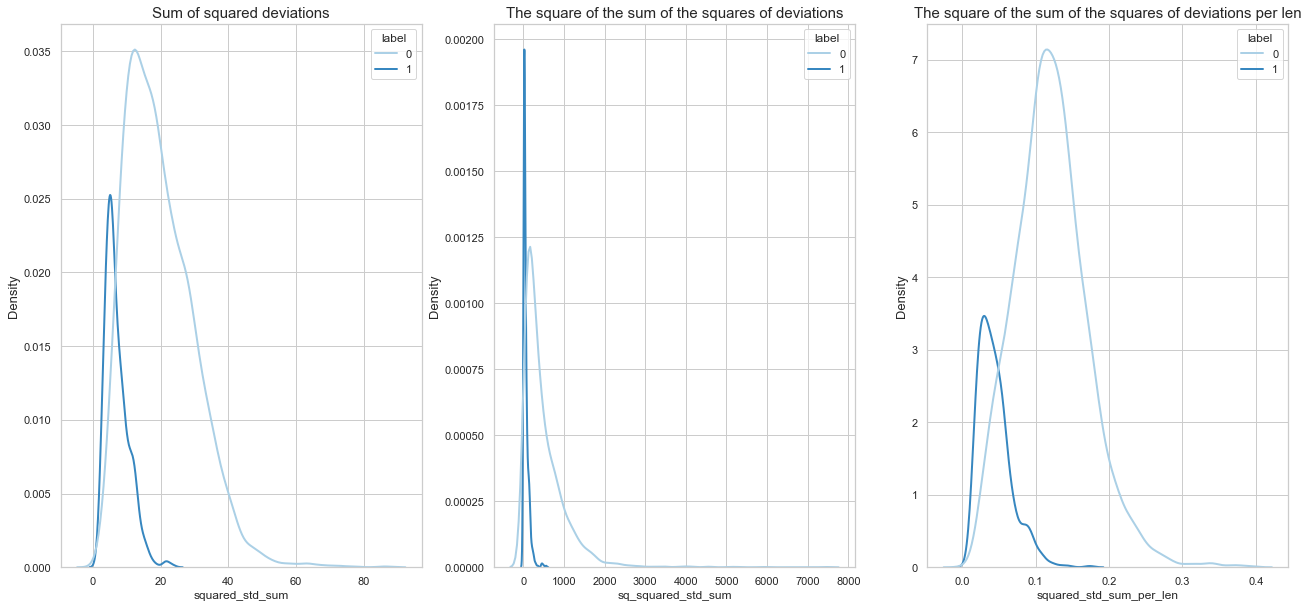

In [12]:
sns.set(rc={'figure.figsize':(22, 10)})
sns.set_style('whitegrid')

fig, ax = plt.subplots(1,3)
sns.set_context("notebook", 
                font_scale=1, 
                rc={"lines.linewidth": 2})
plot = sns.kdeplot(train_df['squared_std_sum'], hue=train['label'], ax=ax[0], palette='Blues');
plot.set_ylabel("Density", fontsize=13)
plot.set_title("Sum of squared deviations", fontsize=15);

plot = sns.kdeplot(train_df['sq_squared_std_sum'], hue=train['label'], ax=ax[1], palette='Blues');
plot.set_ylabel("Density", fontsize=13)
plot.set_title("The square of the sum of the squares of deviations", fontsize=15);

plot = sns.kdeplot(train_df['squared_std_sum_per_len'], hue=train['label'], ax=ax[2], palette='Blues');
plot.set_ylabel("Density", fontsize=13)
plot.set_title("The square of the sum of the squares of deviations per len", fontsize=15);

### Спектральные данные

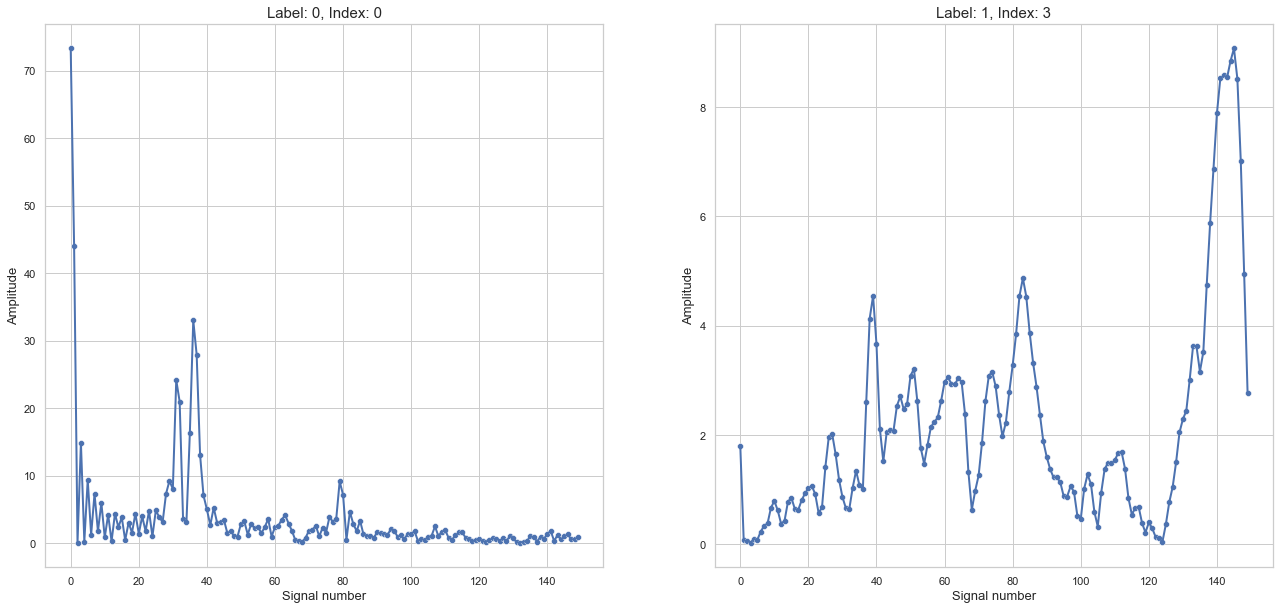

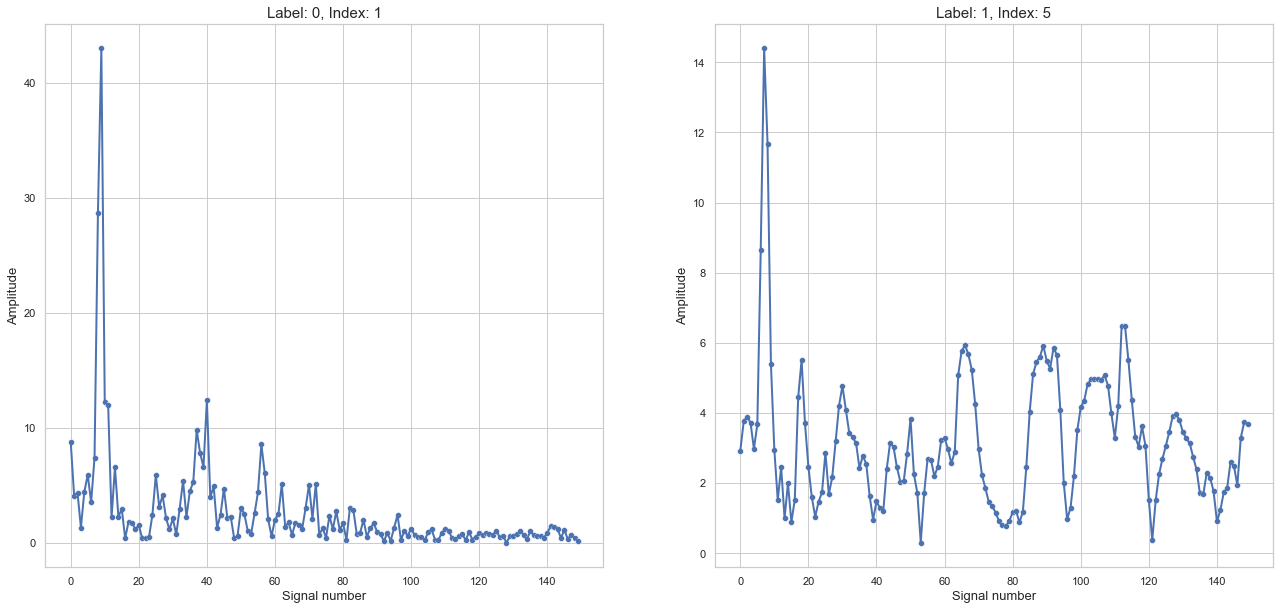

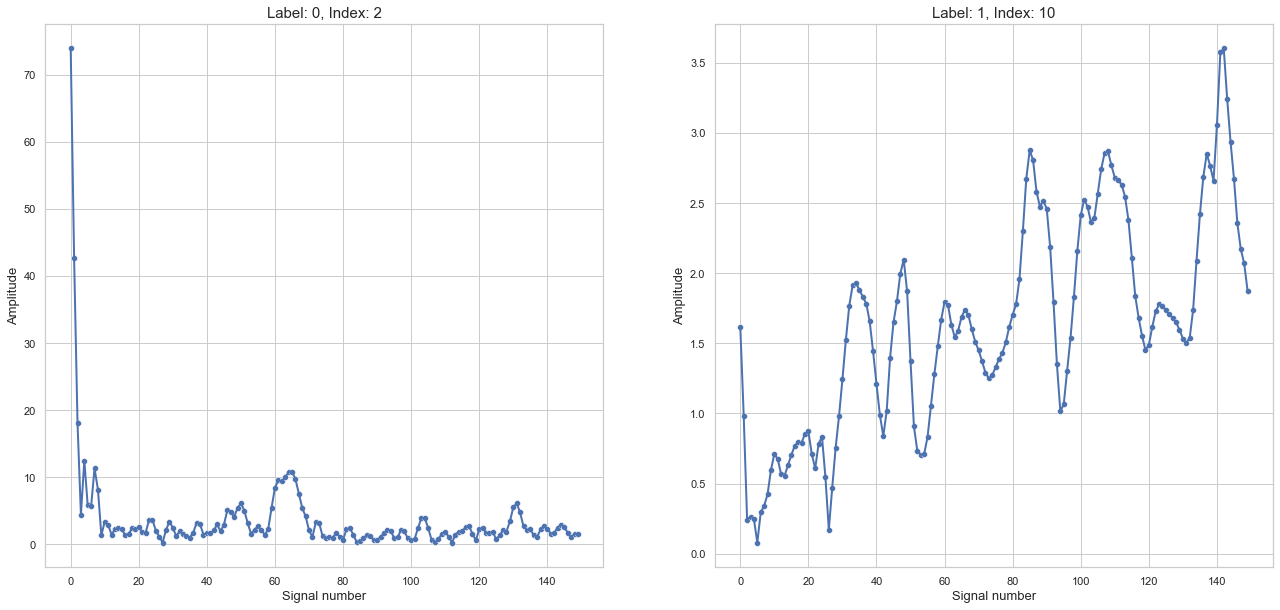

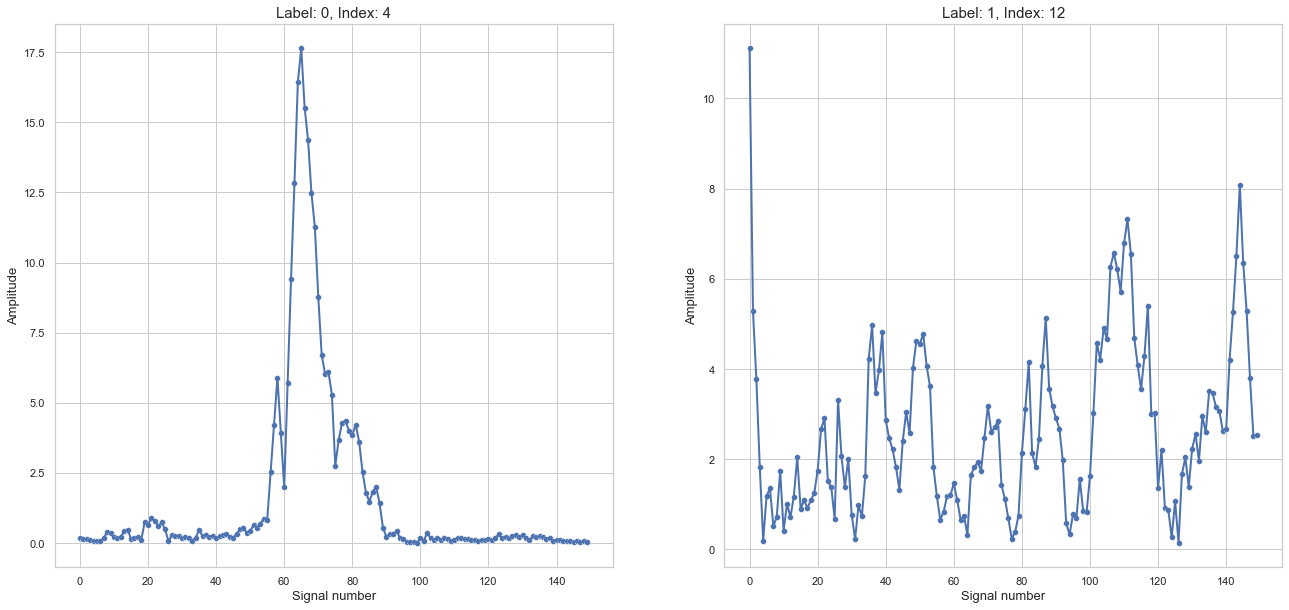

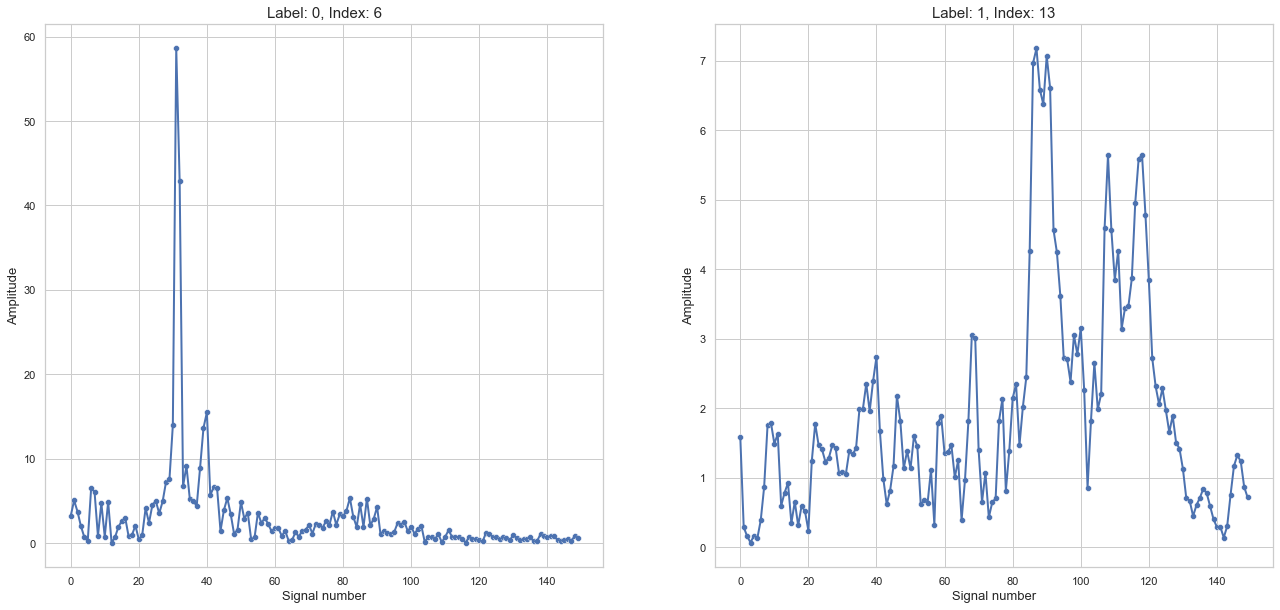

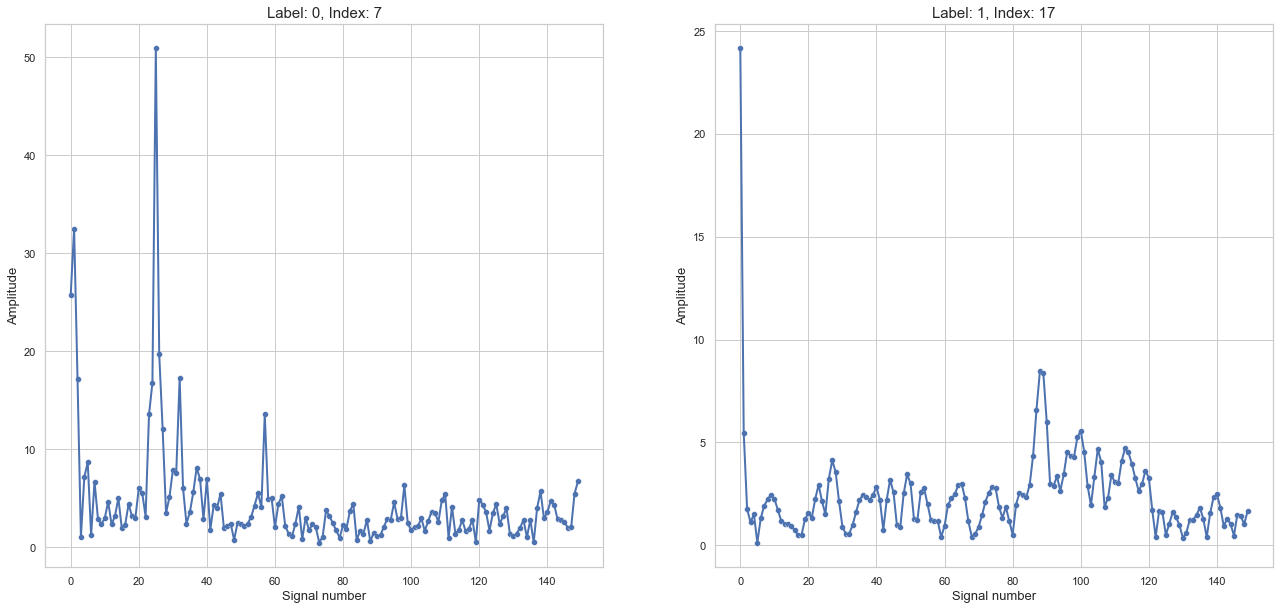

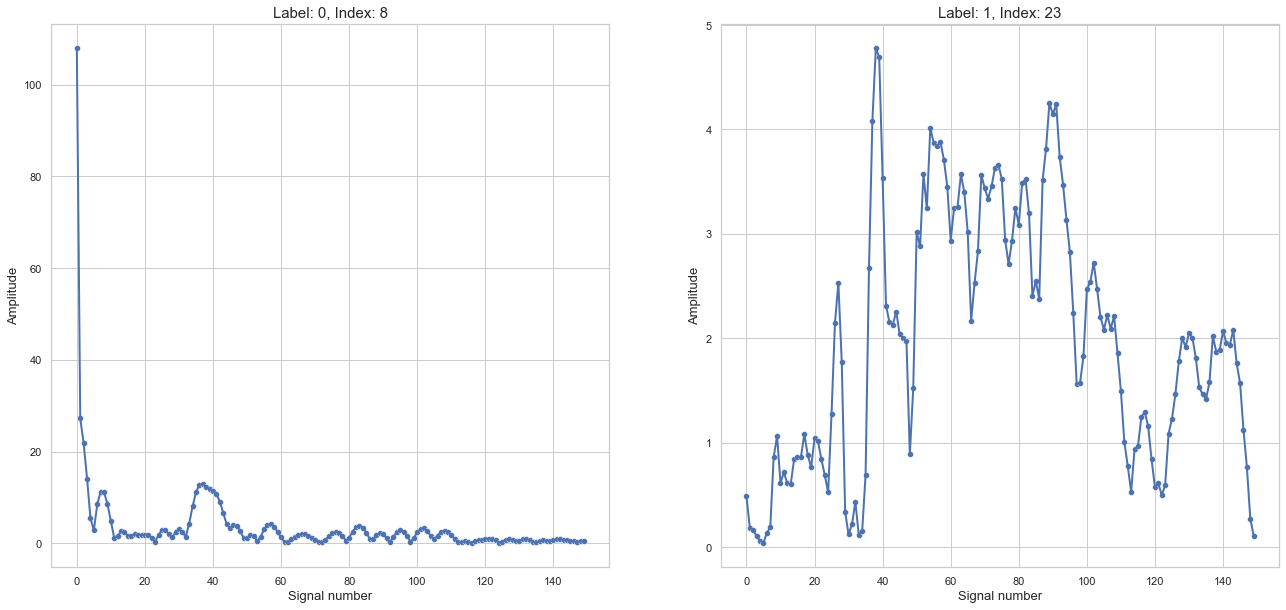

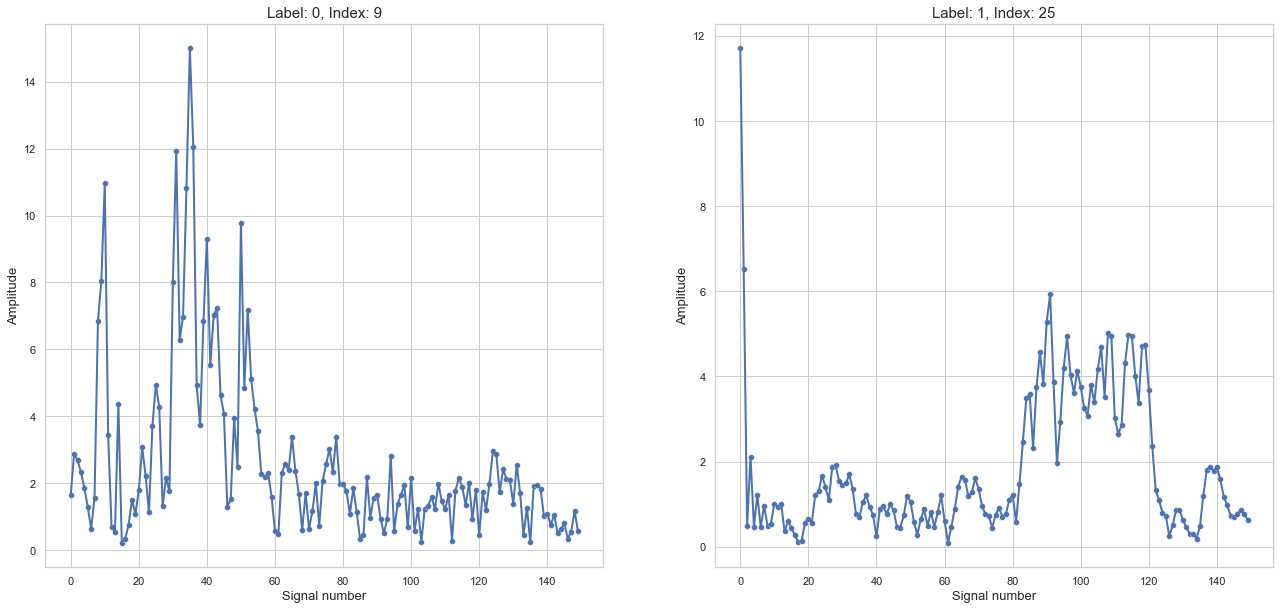

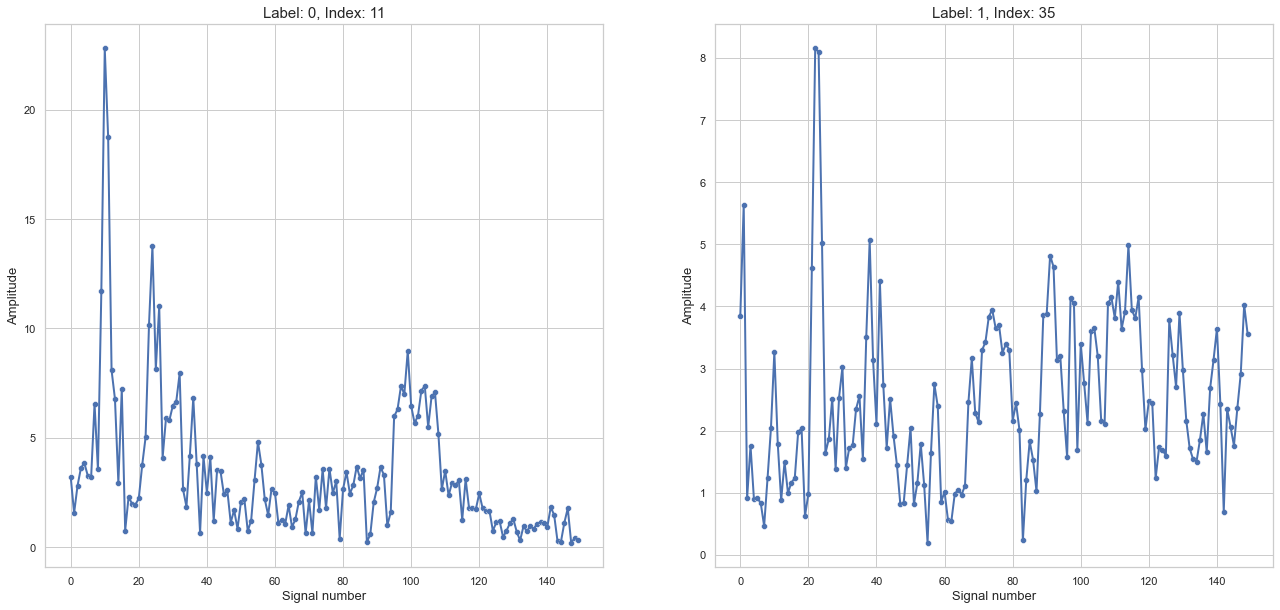

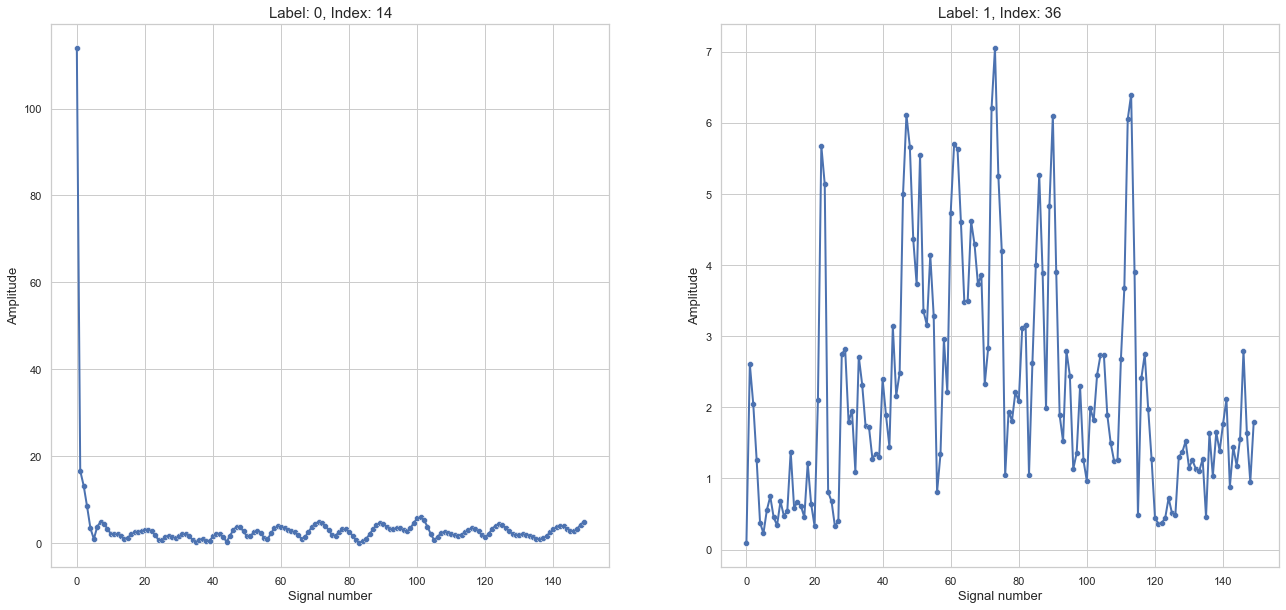

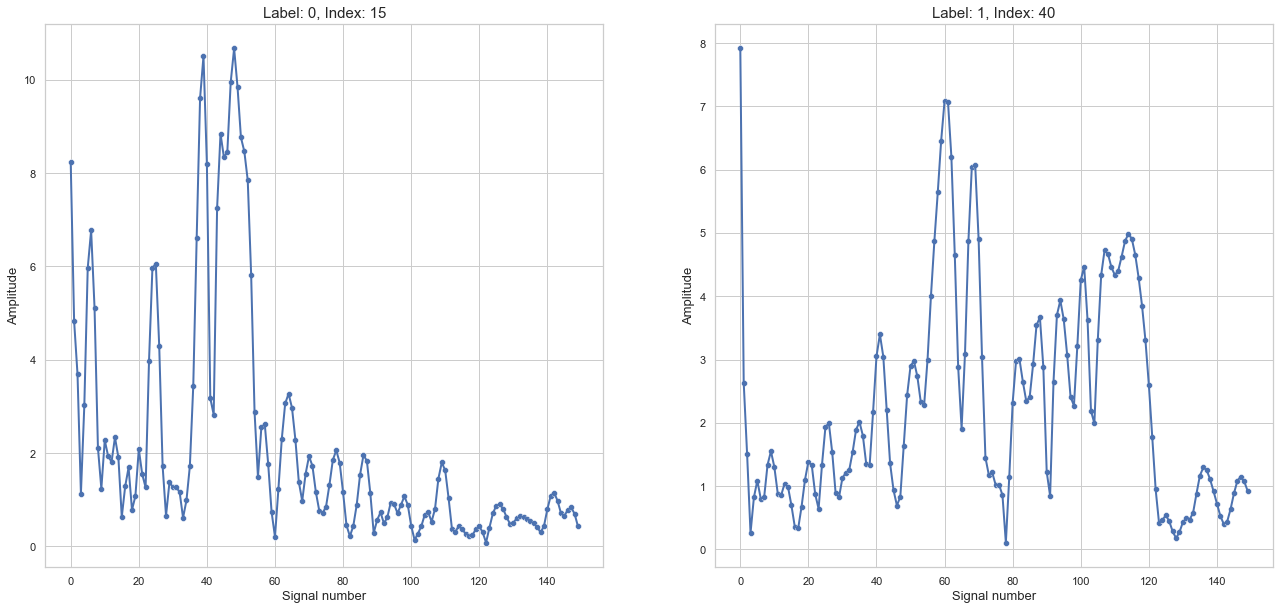

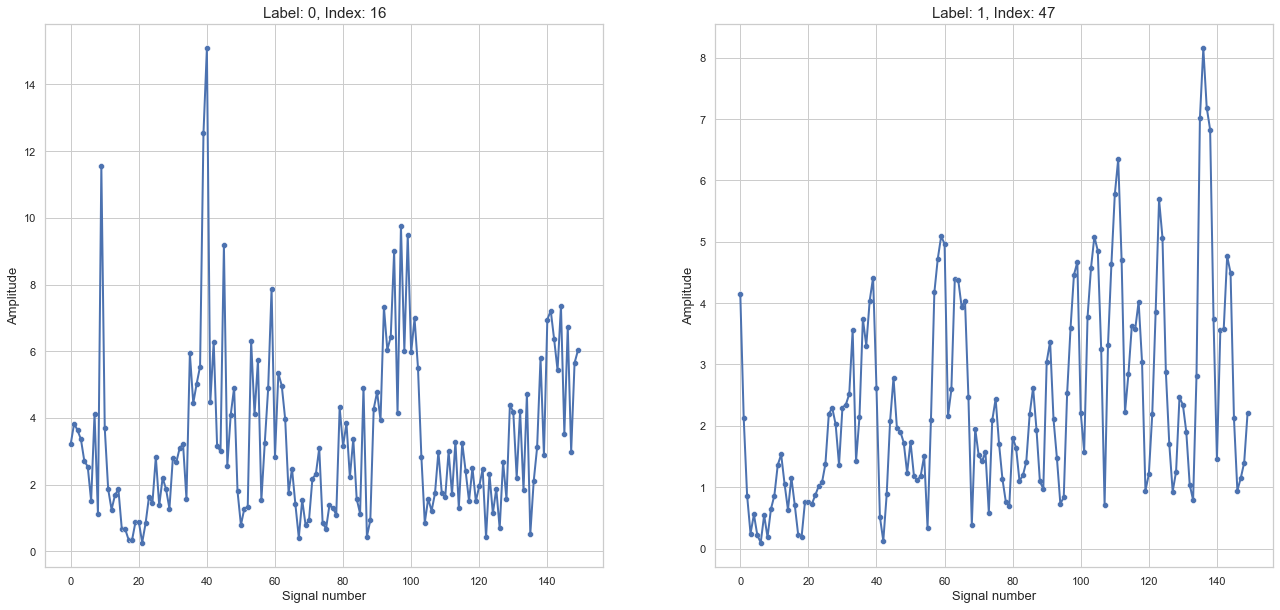

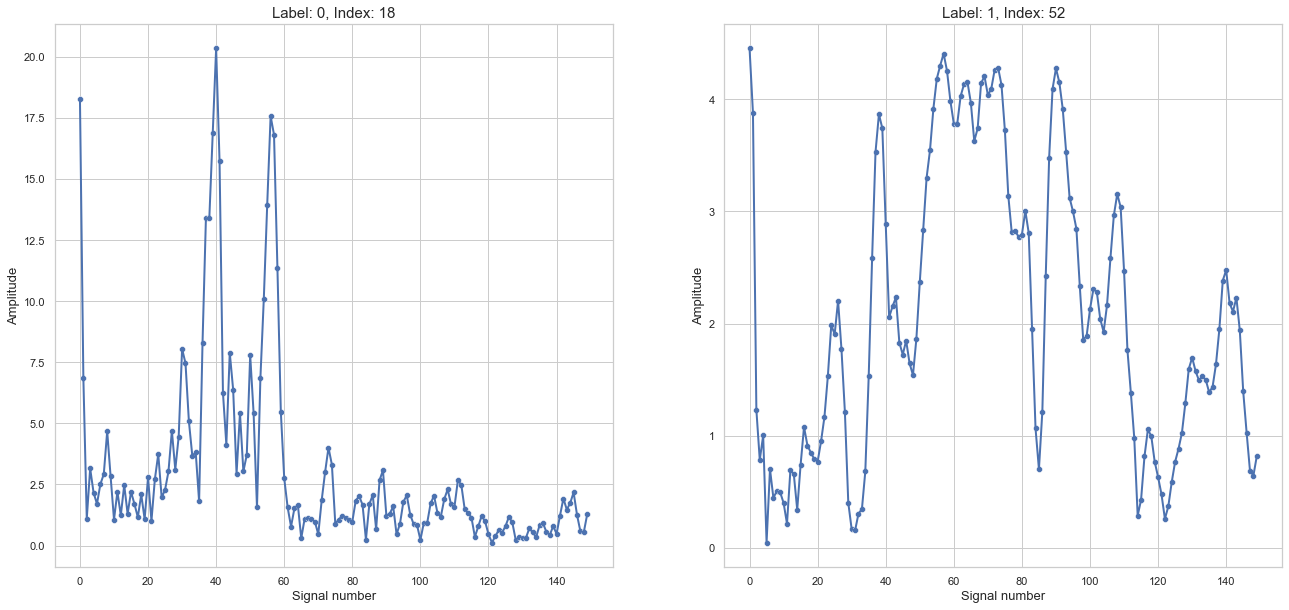

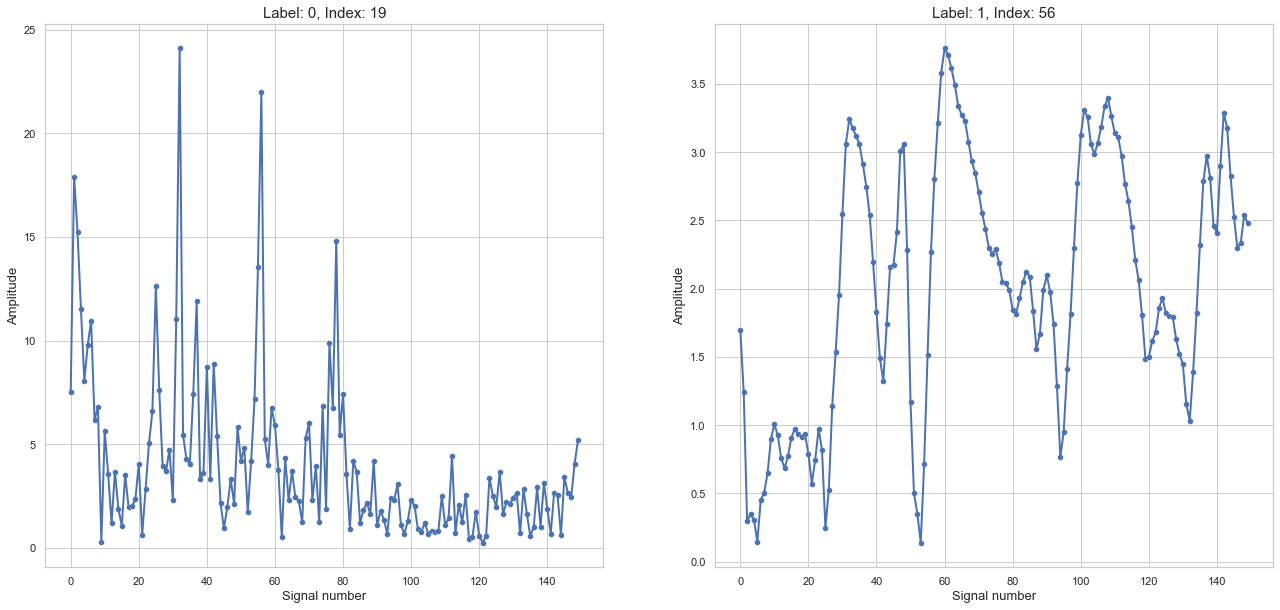

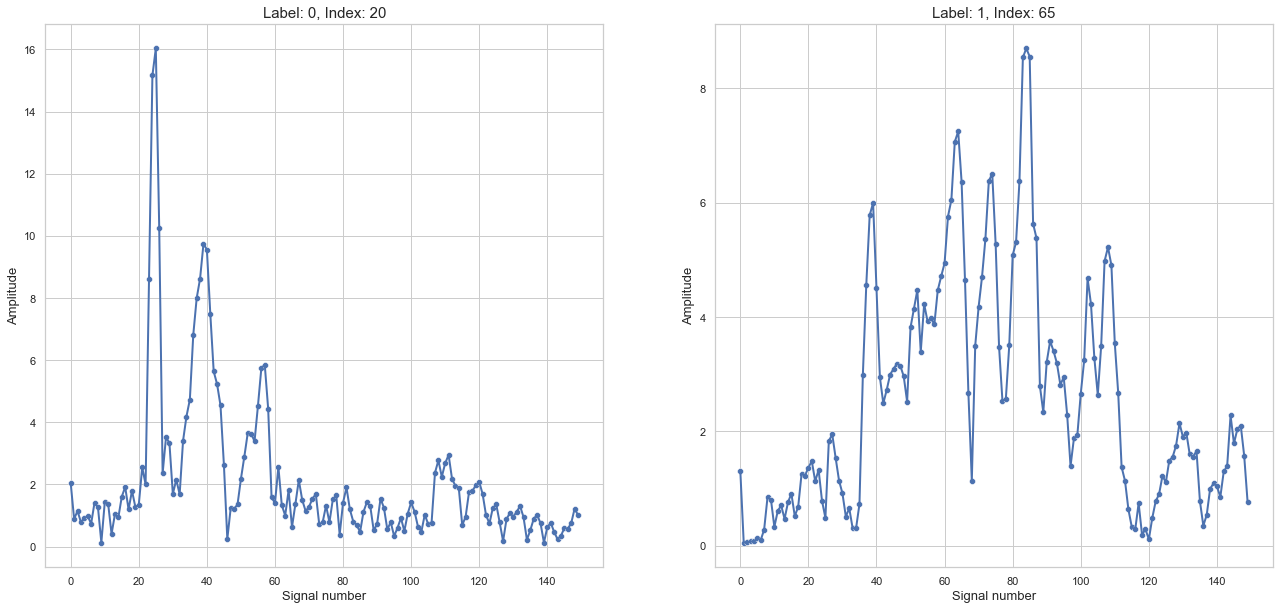

In [13]:
sns.set(rc={'figure.figsize':(22, 10)})
sns.set_style('whitegrid')

data_cols = ["data_" + str(i + 1) for i in range(300)]
spec_data_cols = ["s_" + data_cols[i] for i in range(150)]

spec_data_train = train_df[spec_data_cols].values
spec_data_test = test_df[spec_data_cols].values

draw_data(spec_data_train, 15)

### Признаки из "временных рядов"

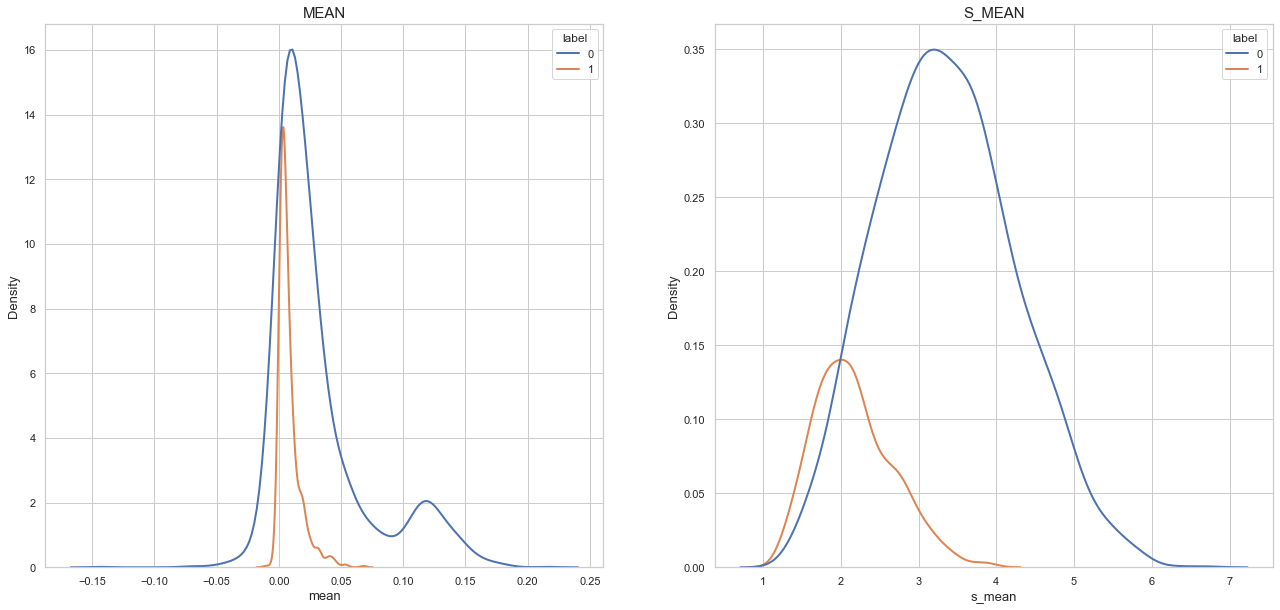

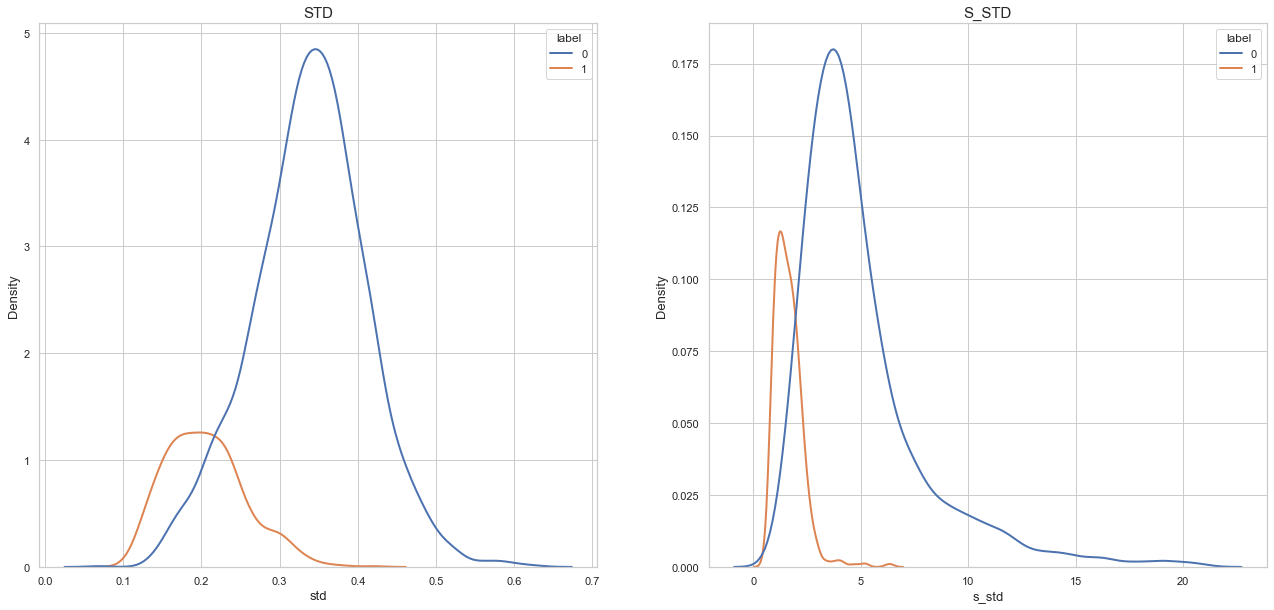

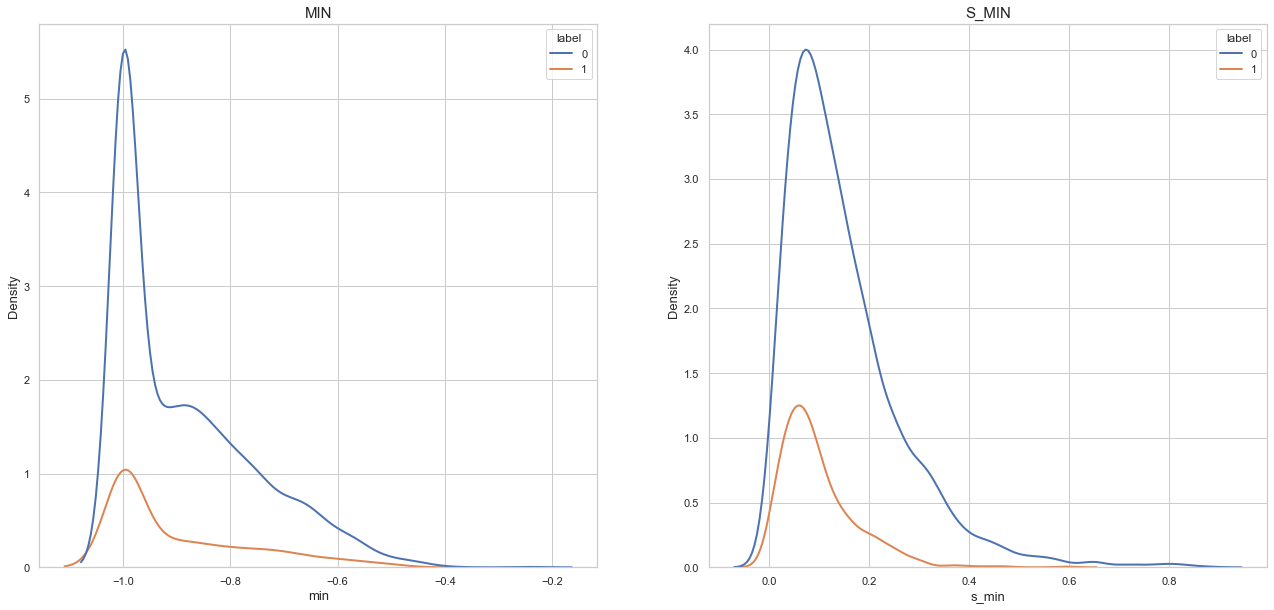

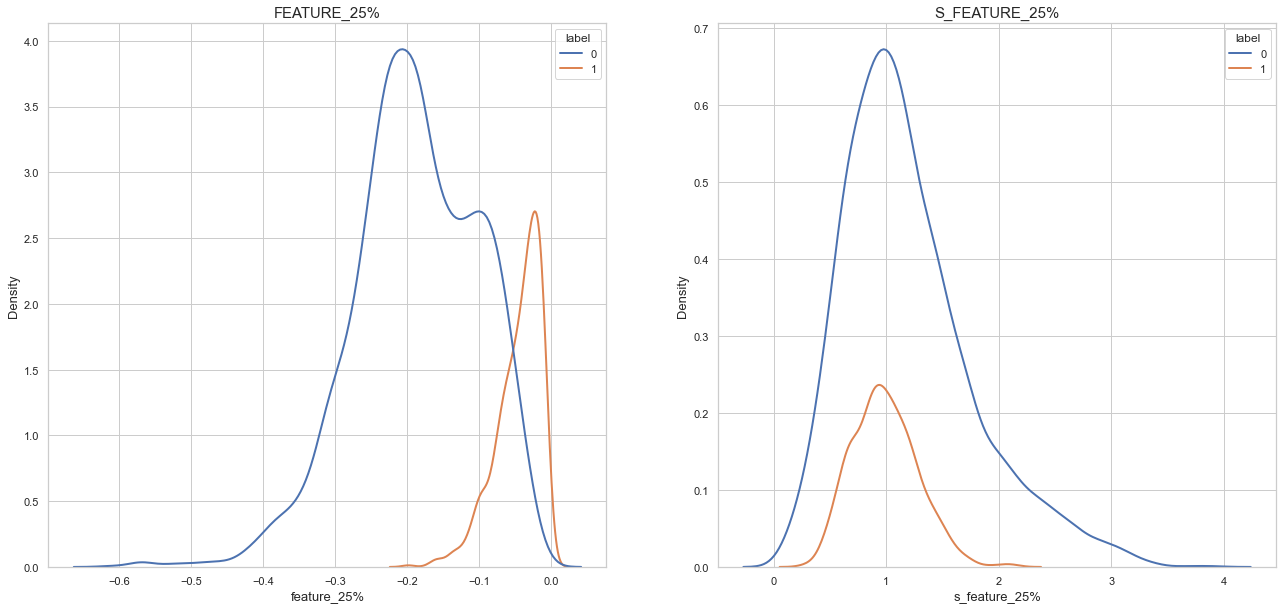

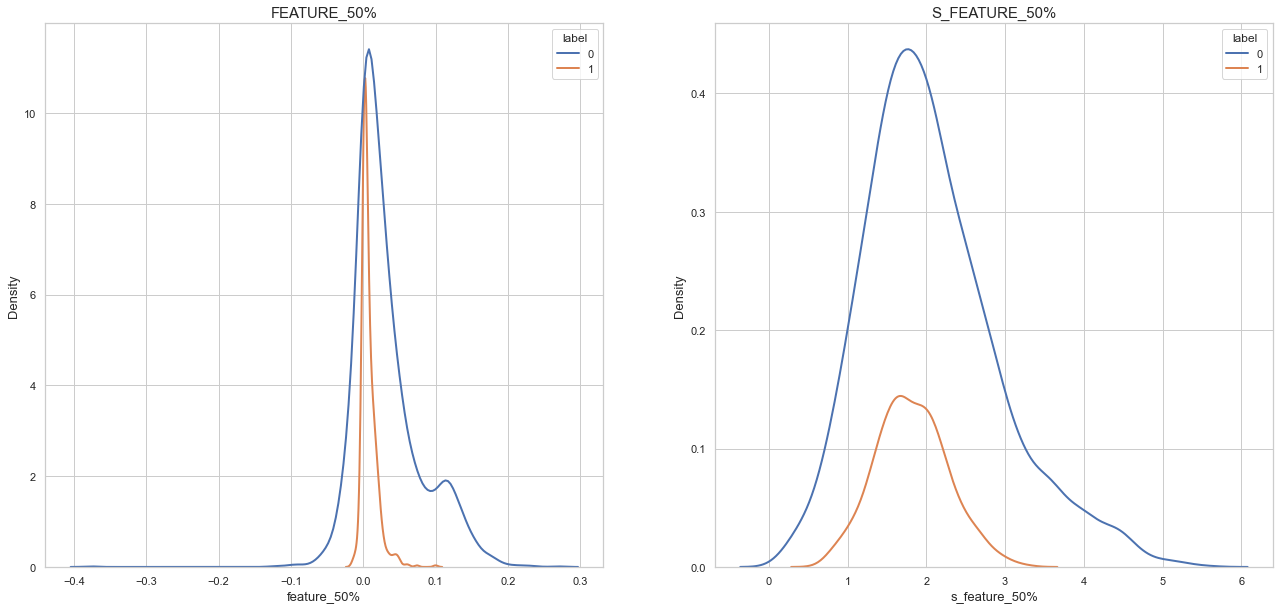

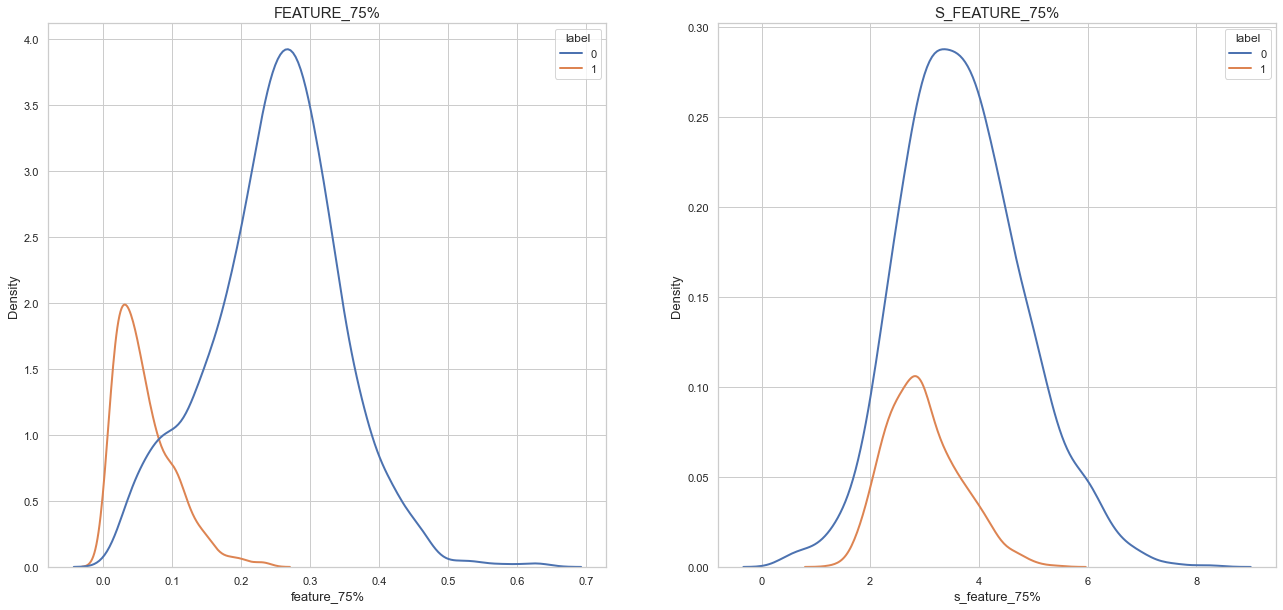

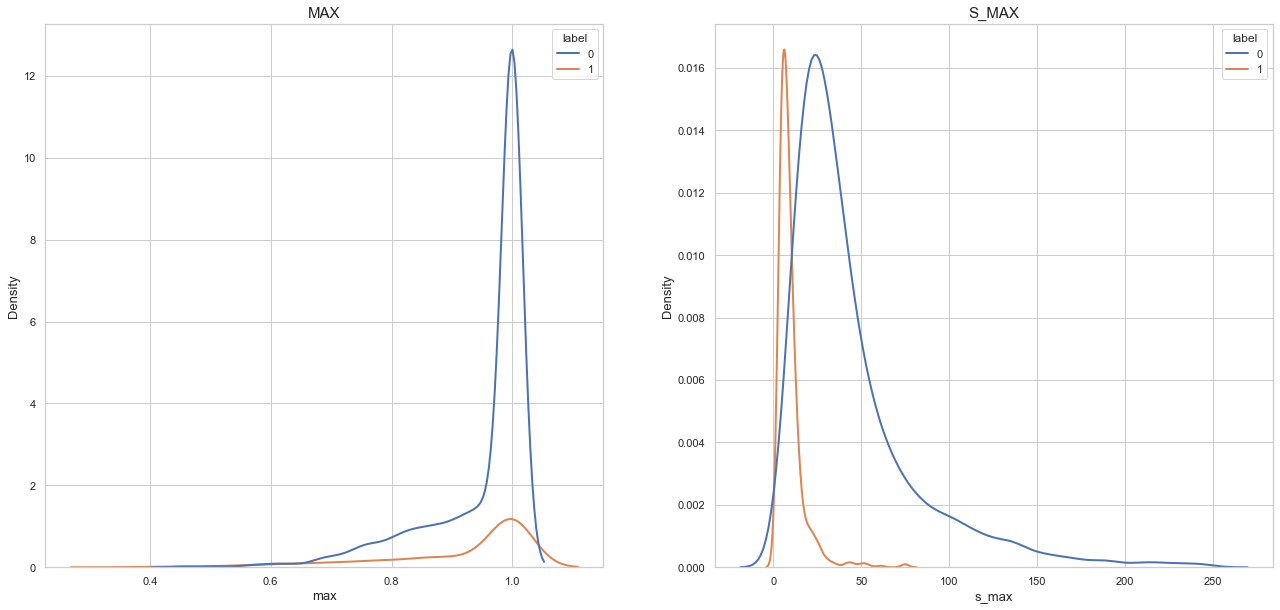

In [14]:
sns.set(rc={'figure.figsize':(22, 10)})
sns.set_style('whitegrid')

statistical_signs = ["mean", "std", "min", "feature_25%", "feature_50%", "feature_75%", "max"]
spec_statistical_signs = ["s_" + statistical_signs[i] for i in range(len(statistical_signs))]

for sign in range(len(statistical_signs)):
    
    fig, ax = plt.subplots(1,2)
    sns.set_context("notebook", 
                font_scale=1, 
                rc={"lines.linewidth": 2})
    plot = sns.kdeplot(train_df[statistical_signs[sign]], 
                       hue=targets, ax=ax[0])
    plot.set_xlabel(statistical_signs[sign], fontsize=13)
    plot.set_ylabel("Density", fontsize=13)
    plot.set_title(statistical_signs[sign].upper(), fontsize=15);
    
    plot = sns.kdeplot(train_df[spec_statistical_signs[sign]], 
                       hue=targets, ax=ax[1])
    plot.set_xlabel(spec_statistical_signs[sign], fontsize=13)
    plot.set_ylabel("Density", fontsize=13)
    plot.set_title(spec_statistical_signs[sign].upper(), fontsize=15);

### Визуализация с помощью t-SNE
t-SNE (t-Distributed Stochastic Neighbor Embedding) - это метод многомерного шкалирования, который используется для визуализации высокоразмерных данных в двух или трех измерениях.

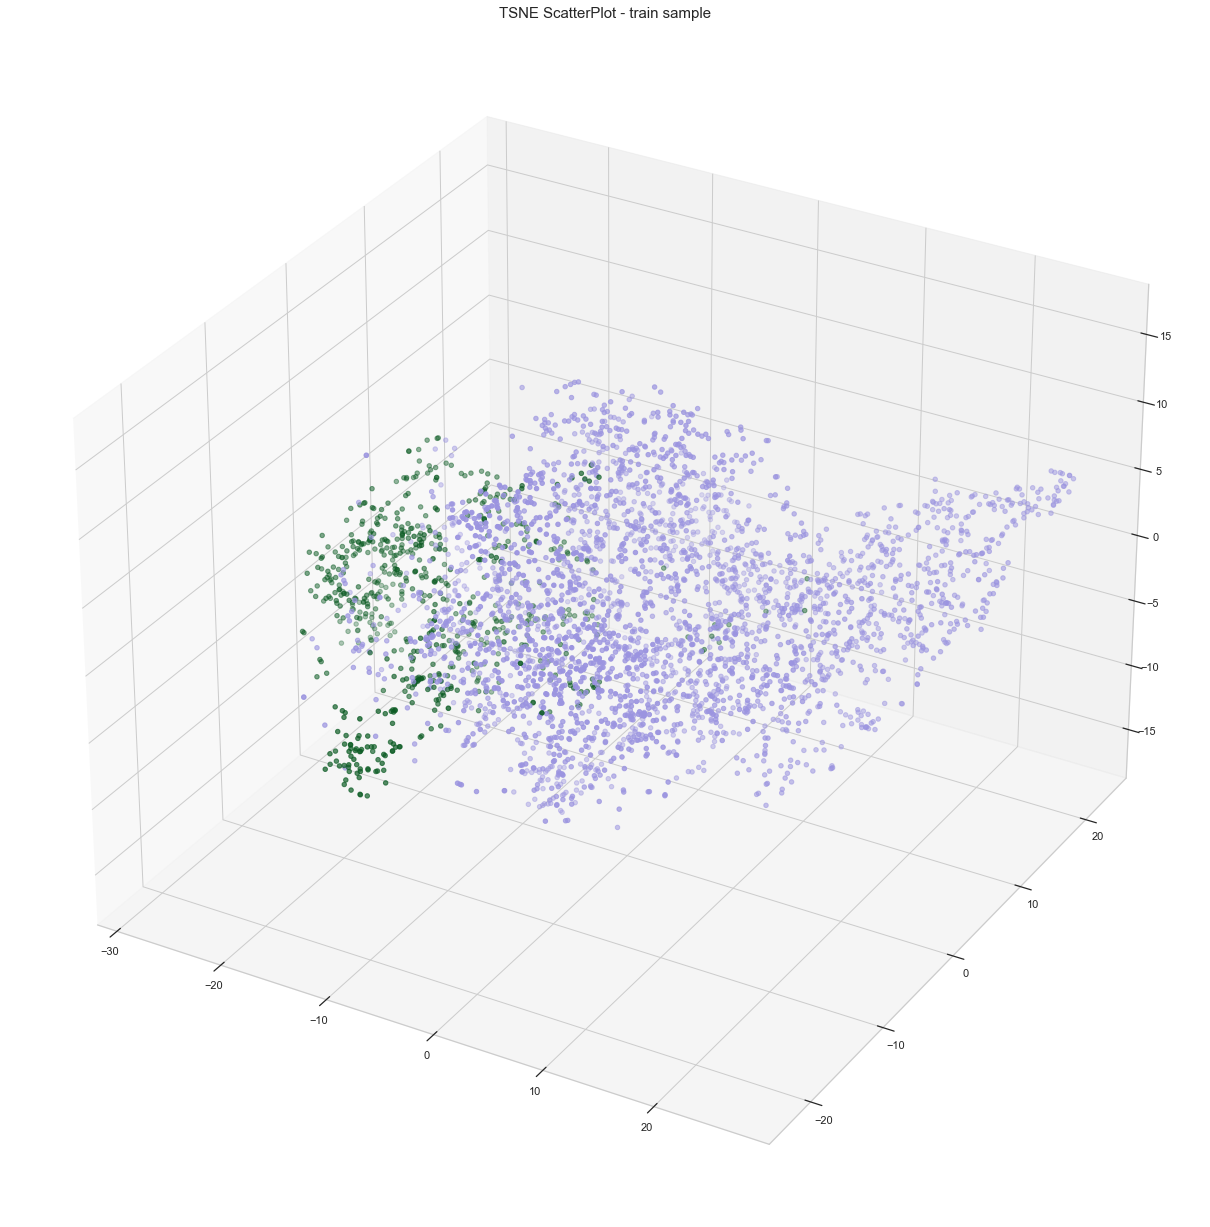

In [15]:
tsne = TSNE(n_components=3, random_state=17)
X_tsne = tsne.fit_transform(train_df[spec_data_cols])

fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pd.DataFrame(X_tsne)[0].values,
           pd.DataFrame(X_tsne)[1].values, 
           pd.DataFrame(X_tsne)[2].values, 
           c=targets.map({0: '#9b94e0', 1: '#0b5b23'}));
plt.title("TSNE ScatterPlot - train sample", fontsize=15)
plt.show()

### Визуализация признаков плотности мощности звука

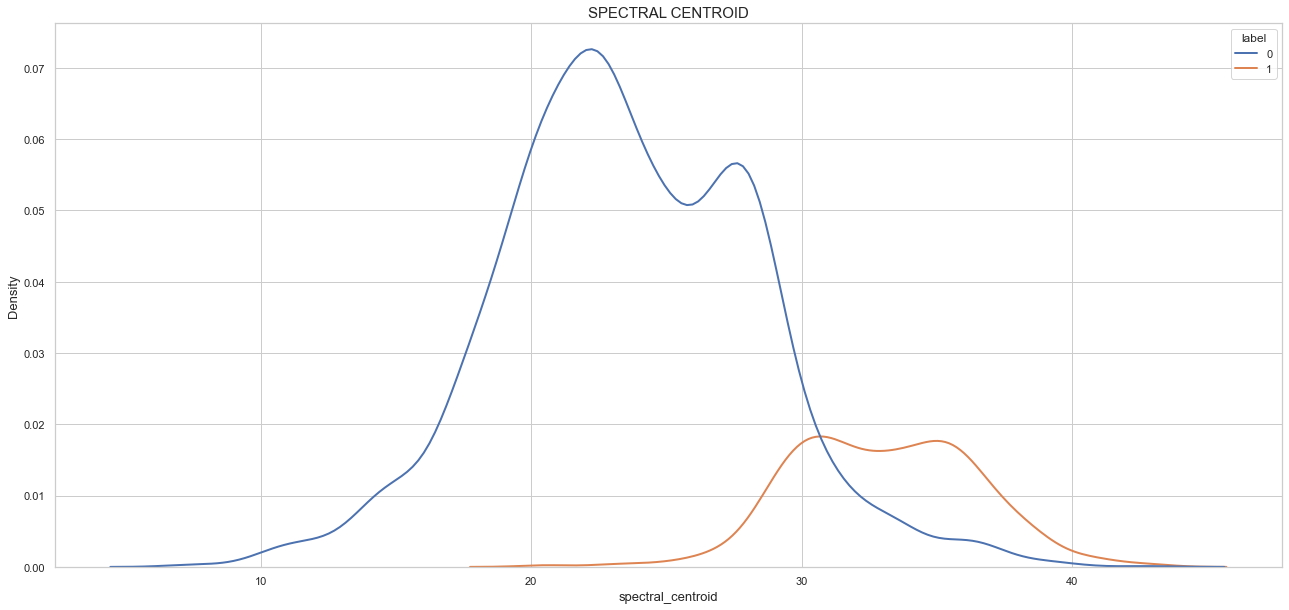

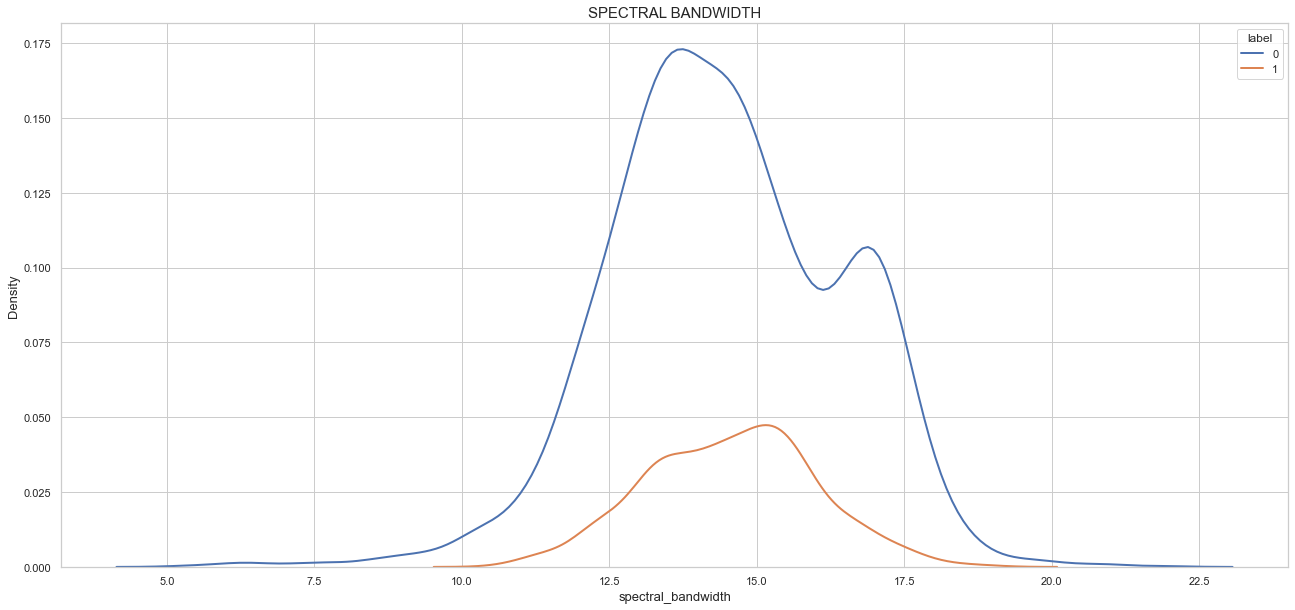

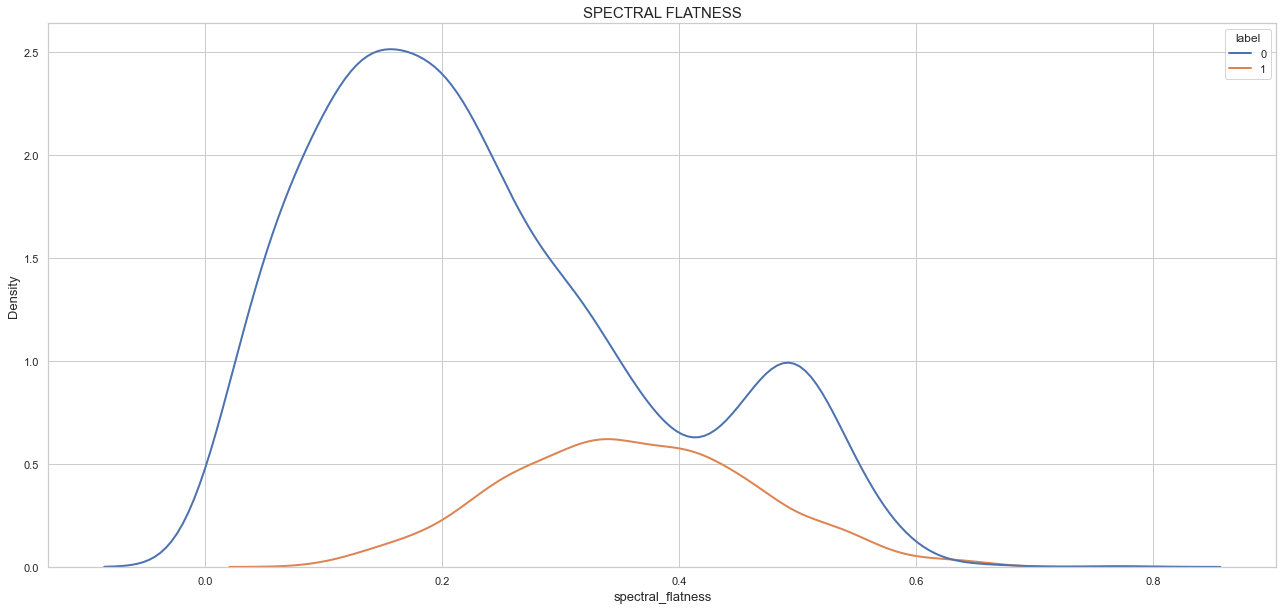

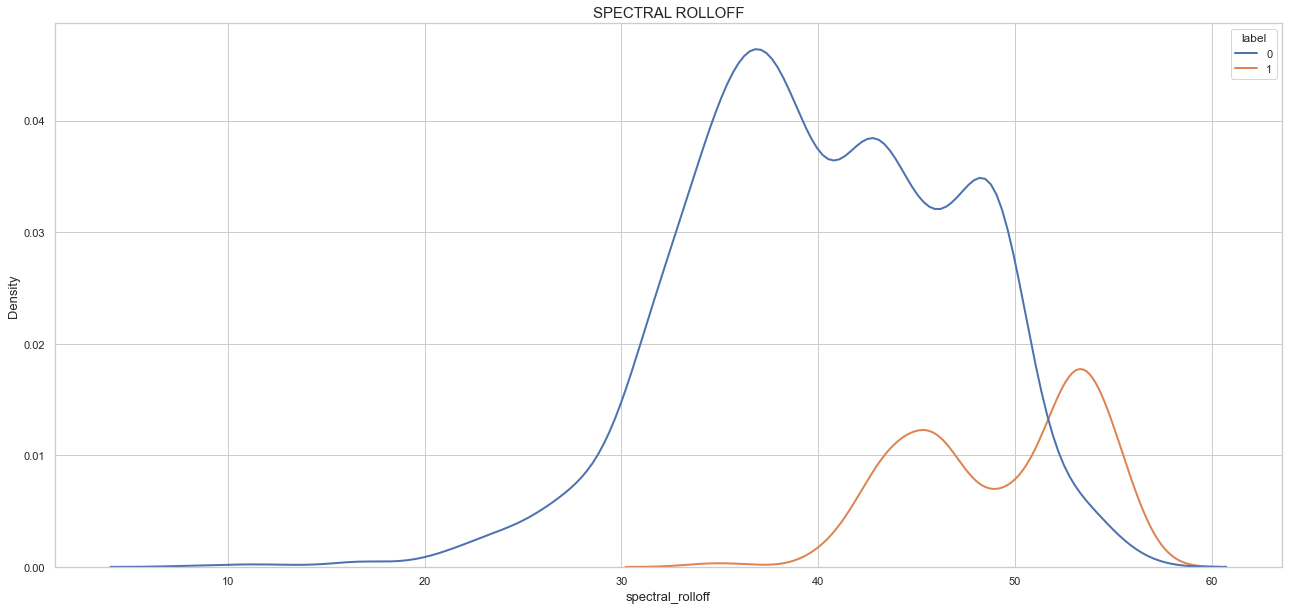

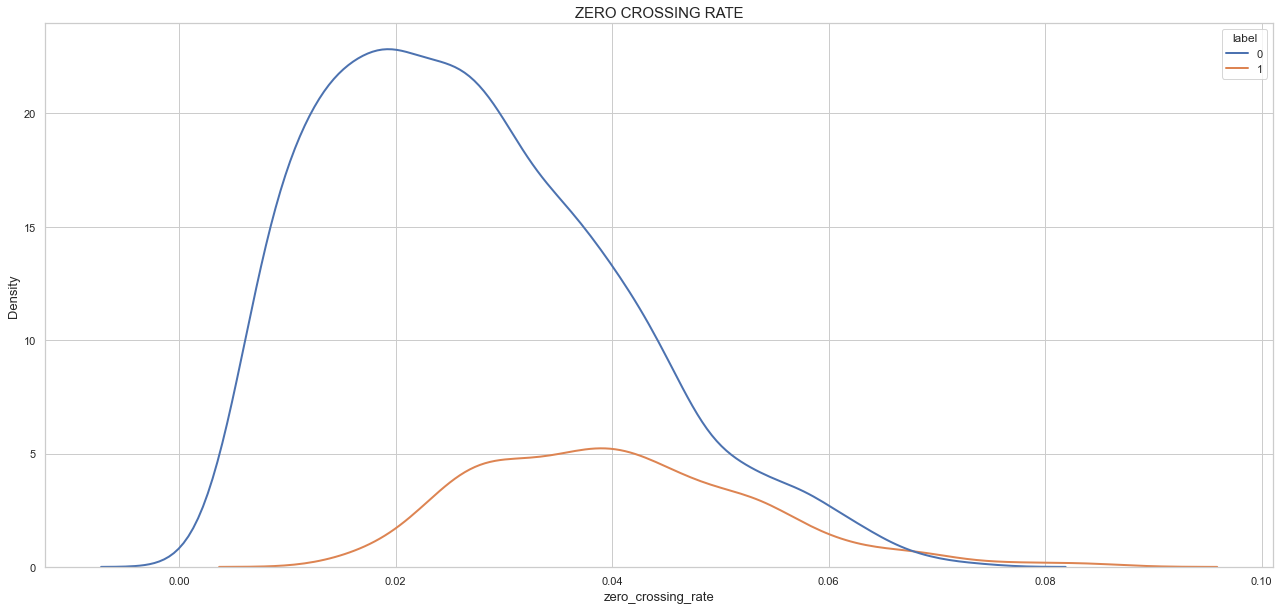

In [16]:
audio_features_cols = ['spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff', 'zero_crossing_rate']

for audio_feature in audio_features_cols:

    sns.set_context("notebook", 
                font_scale=1, 
                rc={"lines.linewidth": 2})
    plot = sns.kdeplot(train_df[audio_feature], 
                       hue=targets)
    plot.set_xlabel(audio_feature, fontsize=13)
    plot.set_ylabel("Density", fontsize=13)
    plot.set_title(audio_feature.upper().replace("_", " "), fontsize=15);
    plt.show()

# 3. Обучение CatBoost

In [17]:
# создаем выборки X и y
X = train_df
y = targets

# разделяем на train и holdout
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=17)

# балансируем выборки
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_, y_ = ros.fit_resample(X, y)

# создаем объекты Pool для обучения и тестирования модели
train_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_holdout, label=y_holdout)

In [18]:
X_train.shape, X_holdout.shape

((5006, 476), (759, 476))

### Кросс-валидация для CatBoostClassifier

In [19]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )
    

params = {
    'loss_function': 'Logloss',
    'iterations': 300,
    'custom_loss': 'F1',
    'learning_rate': 0.05,
    'task_type':'CPU',
}

shuffle_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
cv_data = cv(
    params=params,
    pool=Pool(data=X_, label=y_),
    verbose=False,
    folds=shuffle_split,
    plot=True
)

print_cv_summary(cv_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.04059950707
bestIteration = 298

Training on fold [1/5]

bestTest = 0.04157435942
bestIteration = 299

Training on fold [2/5]

bestTest = 0.03541640066
bestIteration = 299

Training on fold [3/5]

bestTest = 0.03987084923
bestIteration = 281

Training on fold [4/5]

bestTest = 0.04911335428
bestIteration = 299

Best validation Logloss score : 0.0413±0.0049 on step 299


### Финальное обучение и предсказание

In [20]:
cat_best = CatBoostClassifier(
    random_seed=63,
    loss_function='Logloss',
    iterations=2000,
    custom_loss='F1',
    learning_rate=0.05,
    task_type='CPU',
)

cat_best.fit(
    Pool(data=X_, label=y_),
    verbose=50,
)

0:	learn: 0.6086674	total: 54.3ms	remaining: 1m 48s
50:	learn: 0.0640438	total: 2.65s	remaining: 1m 41s
100:	learn: 0.0308763	total: 5.62s	remaining: 1m 45s
150:	learn: 0.0178909	total: 8.61s	remaining: 1m 45s
200:	learn: 0.0115418	total: 11.4s	remaining: 1m 41s
250:	learn: 0.0080938	total: 14.5s	remaining: 1m 40s
300:	learn: 0.0057517	total: 17.2s	remaining: 1m 37s
350:	learn: 0.0046084	total: 20.1s	remaining: 1m 34s
400:	learn: 0.0036010	total: 22.6s	remaining: 1m 30s
450:	learn: 0.0030209	total: 25.4s	remaining: 1m 27s
500:	learn: 0.0026504	total: 28.1s	remaining: 1m 24s
550:	learn: 0.0023575	total: 31s	remaining: 1m 21s
600:	learn: 0.0022027	total: 33.5s	remaining: 1m 18s
650:	learn: 0.0021153	total: 36.8s	remaining: 1m 16s
700:	learn: 0.0019976	total: 39.7s	remaining: 1m 13s
750:	learn: 0.0019556	total: 42.2s	remaining: 1m 10s
800:	learn: 0.0019454	total: 44.9s	remaining: 1m 7s
850:	learn: 0.0019389	total: 48.3s	remaining: 1m 5s
900:	learn: 0.0019386	total: 51.4s	remaining: 1m 2s


In [21]:
test_pool = Pool(data=test_df)
sub_sample['label'] = cat_best.predict(test_pool).astype(int)
sub_sample['label'].value_counts()

0    226
1    224
Name: label, dtype: int64

In [22]:
sub_sample.to_csv('catboost_predict.csv', index=False)